In [1]:
from attrdict import AttrDict
import itertools
try:
	import cPickle as pickle
except ImportError:
	import pickle
    
from src.dataloader import *
from src.dataloader_primitives import *
from src.model_dual import *
from src.model_target_primitives import  *
from src.model_target import *
from src.train import *
from src.train_target import *
from src.dataset.visualizer import WorldPlotter
device = 'cuda:0'
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import stanza
from nltk import Tree

/opt/conda/envs/please_1/lib/python3.6/site-packages/gym/core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
class Plotter:
    def __init__(self,include_train=False):
        self.plotters = {}
        if include_train:
            self.plotters["train"] = WorldPlotter(f"./data/ReaSCAN-v1.1/ReaSCAN-compositional/data-compositional-splits.txt")
        for test_split in ["a1","a2","a3","b1","b2","c1","c2"]:
            self.plotters[test_split] = WorldPlotter(f"./data/ReaSCAN-v1.1/ReaSCAN-compositional-{test_split}/data-compositional-splits.txt")
    def show(self,test_split,index,key="test",commands=[],targets=[],show_target=True,show_size=True,wrong_target=None):
        self.plotters[test_split].show(index,key=key,commands=commands,targets=targets,show_target=show_target,show_size=show_size,wrong_target=wrong_target)
world_plotter = Plotter(include_train=False)

In [3]:

stanza_model = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency',)
# Convert a stanza Document object to an NLTK Tree object
def document_to_tree(text):
    if isinstance(text,list):
        text = " ".join(text)
    if "(" in text:
        text = text.replace("(",'').replace(")",'')
    
    document = stanza_model(text)
    tree_structure = document.sentences[0].constituency

    tree_structure = str(tree_structure).replace("'", "").replace("[",'(').replace("]",')')
    tree = Tree.fromstring(tree_structure)
    tree.pretty_print()

# Parse the sentence
class MemoryDataLoader:
    def __init__(self):
        self.data_loaders = {}
            
    def get(self,test_path, device, batch_size,dataloader_fn=dataloader):
        data_loader_key = f"{test_path}-{device}-{batch_size}"
        if data_loader_key not in self.data_loaders:
            self.data_loaders[data_loader_key] = dataloader_fn(test_path, device, batch_size=batch_size, random_shuffle=False)
        return self.data_loaders[data_loader_key]
memory_data_loader = MemoryDataLoader()

2023-08-13 02:52:50 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-13 02:52:51 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-13 02:52:51 INFO: Use device: gpu
2023-08-13 02:52:51 INFO: Loading: tokenize
2023-08-13 02:52:54 INFO: Loading: pos
2023-08-13 02:52:55 INFO: Loading: constituency
2023-08-13 02:52:55 INFO: Done loading processors!


In [4]:
stanza_model_dep = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,depparse')

2023-08-13 02:52:56 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-13 02:52:56 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-08-13 02:52:56 INFO: Use device: gpu
2023-08-13 02:52:56 INFO: Loading: tokenize
2023-08-13 02:52:56 INFO: Loading: pos
2023-08-13 02:52:57 INFO: Loading: lemma
2023-08-13 02:52:57 INFO: Loading: depparse
2023-08-13 02:52:57 INFO: Done loading processors!


In [5]:
# parse_cache = {}
# def parse(text):
#     if text in parse_cache:
#         return parse_cache[text]
#     parse_cache[text] = str(stanza_model(text).sentences[0].constituency).replace("(","").replace(")","").split()
#     return parse_cache[text]

In [6]:

# # text = "walk to the cylinder that is inside of a yellow box and in the same size as a red circle cautiously"
# # len(text.split()), len(str(stanza_model(text).sentences[0].constituency).replace("(","").replace(")","").split())
# # str(stanza_model_dep(text).sentences[0].dependencies)
# # stanza_model_dep(text)

# run = 'default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420'
# # test_split = 'c2'
# test_split = 'train'
# config, model, command_lang, action_lang = get_model_and_config(run)
# config.batch_size = 1
# # test_path = get_test_data_path(config,test_split)
# test_path = get_train_data_path(config,test_split)

# print("Loading......")
# test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
# lenghts = 0
# parsed_lenghts = 0
# print("Loaded.")
# for x in tqdm(test_dataloader):
#     command =  " ".join(x.input_command[0])
#     parsed = parse(command)
#     lenghts += len(command.split())
#     parsed_lenghts += len(parsed)
#     # break

# print(parsed_lenghts/lenghts)


In [7]:
# doc = stanza_model_dep()

In [8]:
# text = "push the cylinder that is inside of a green box and in the same size as a yellow circle while zigzagging".split()

# text_joined = " ".join(text)

# tokens = ["ROOT"] + text_joined.split()
# text_lenght = len(tokens)
# # masks = np.zeros((text_lenght,text_lenght))
# masks = np.eye(text_lenght)
# doc = stanza_model_dep(text_joined)
# for dependency_parse_items in doc.sentences[0].dependencies:
#     print(dependency_parse_items)
#     dependency_parse_item = dependency_parse_items[2]
#     if dependency_parse_items[2].text == "box":
#         print(dependency_parse_items[2])
#     if dependency_parse_items[0].text == "box":
#         print(dependency_parse_items[0])
#     if dependency_parse_item.head is not None:
#         masks[dependency_parse_item.head, dependency_parse_item.id] = 1
#         masks[dependency_parse_item.id,dependency_parse_item.head] = 1
#         # dependency_parse_item = dependency_parse_items[0]
#         # if dependency_parse_item.head is not None:
#         #     # masks[dependency_parse_item.id,dependency_parse_item.head] = 1
#         #     masks[dependency_parse_item.head, dependency_parse_item.id] = 1 
# print(masks) 
        

In [9]:
def get_model_and_config(run,primitives=False):

    with open(f'./models/{run}/config.p', 'rb') as f:
        config = AttrDict(pickle.load(f))
    config.device = device
    config.visualization = True
    config.single_token_decoding = 0
    command_lang = torch.load(f'./models/{run}/command_lang.pth')
    action_lang = torch.load(f'./models/{run}/action_lang.pth')
    model = MultiModalModel_Dual(config).to(device)
    try:
        if primitives:
            model = PrimitivesTargetPredictor(model,config)
            checkpoint = torch.load(f'./models/{run}/target_predictor_-1.pt', map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            checkpoint = torch.load(f'./models/{run}/model.pt', map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
    except Exception as e:
        print(e)
    model = model.to(device)
    return config, model, command_lang, action_lang

In [10]:
def get_test_data_path(config,test_split):
    return f"{config.data_path}/ReaSCAN-v1.1/ReaSCAN-compositional-{test_split}/test.json"
def get_train_data_path(config,file="train",primitives=False):
    if primitives:
        return f"{config.data_path}/ReaSCAN-v1.1/ReaSCAN-compositional/{file}_spatial.json"
    return f"{config.data_path}/ReaSCAN-v1.1/ReaSCAN-compositional/{file}.json"

In [11]:
# run = 'default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420'
# # test_split = 'c2'
# test_split = 'a1'
# config, model, command_lang, action_lang = get_model_and_config(run)
# config.batch_size = 1
# test_path = get_test_data_path(config,test_split)

# test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
# smallest_command = None
# smallest_command_lenght = float('inf') 
# for x in test_dataloader:
#     command = x.input_command[0]
#     if 10 < len(command) < smallest_command_lenght:
#         smallest_command = command
#         smallest_command_lenght = len(command)
    
# print(smallest_command_lenght," ".join(smallest_command))


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 2, 5)
push the cylinder that is inside of a green box and in the same size as a yellow circle while zigzagging
Ground Truth ['walk', 'turn left', 'walk']
Predicion    ['turn left', 'turn left', 'walk', 'turn right', 'walk', 'turn left', 'walk', 'turn right', 'walk']


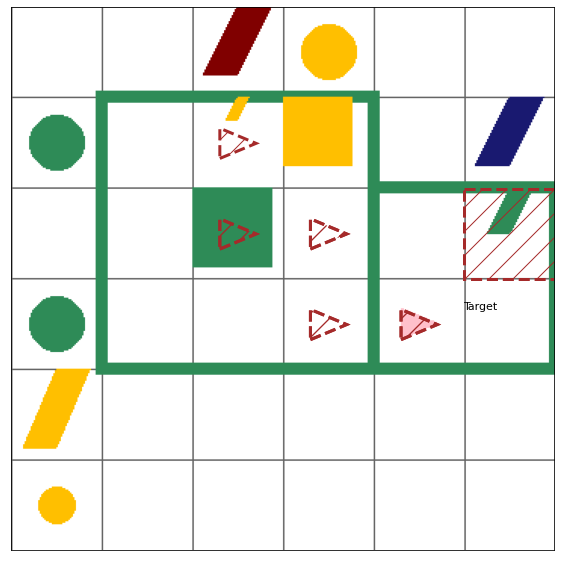

walk


###################### (8, 37, 24)
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']
['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

['ROOT', 'push', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'green', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle', 'while', 'zigzagging']


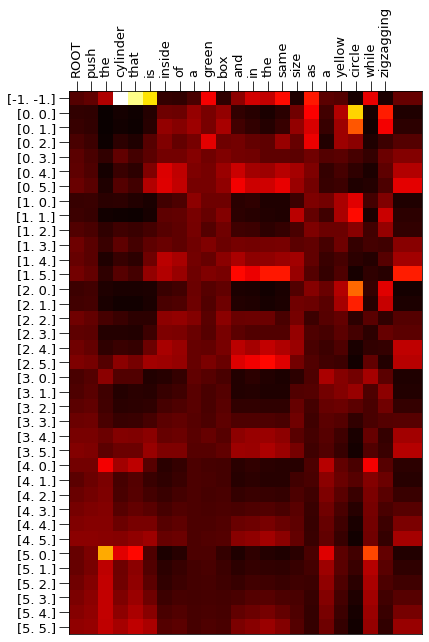

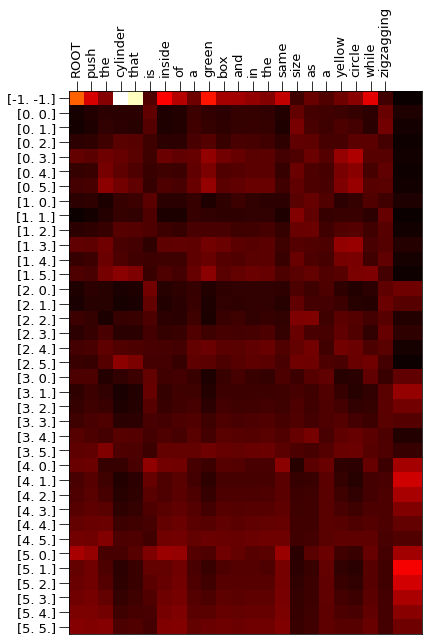

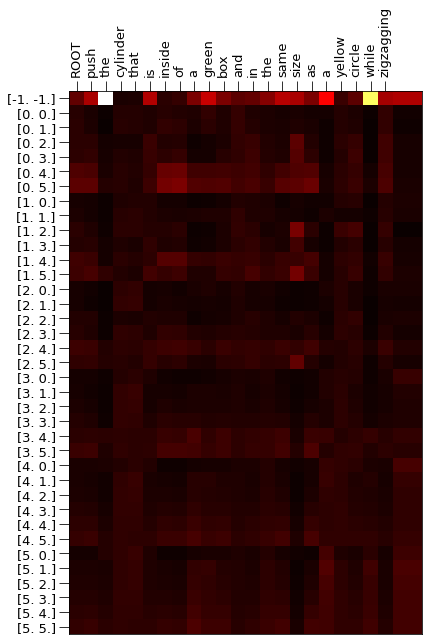

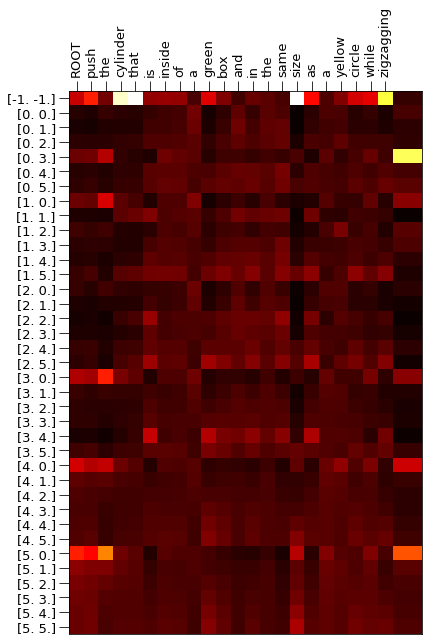

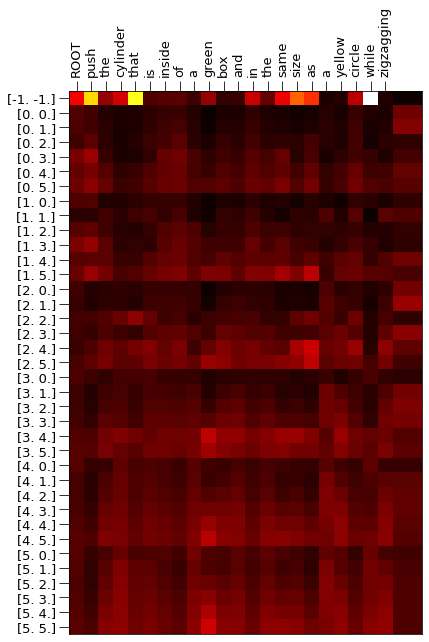

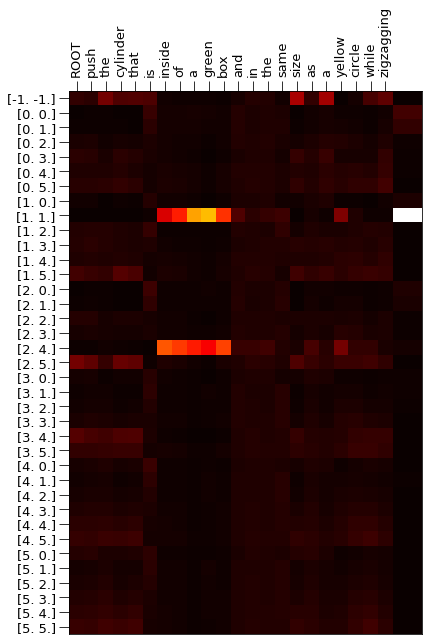

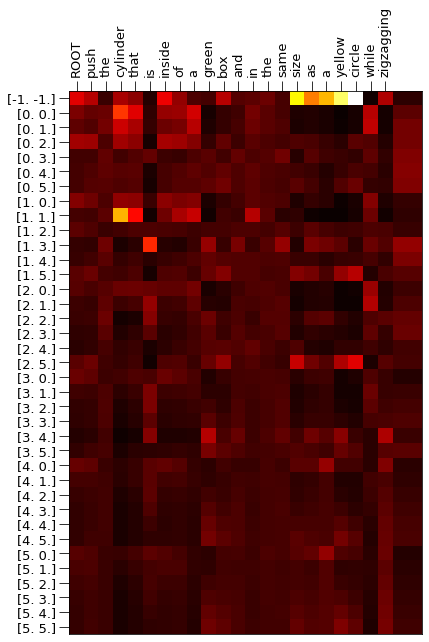

<Figure size 720x720 with 0 Axes>

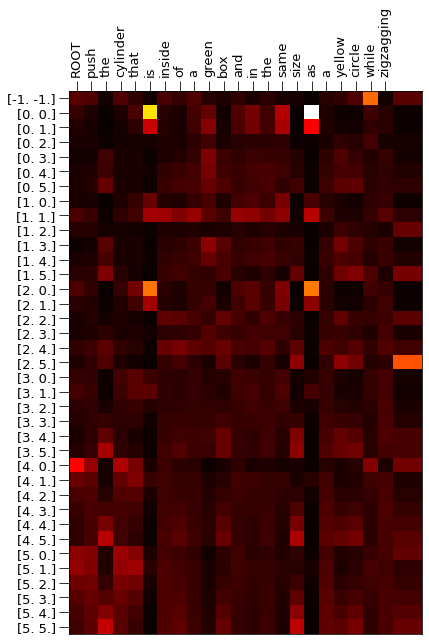

0it [00:04, ?it/s]


In [20]:


def plot_text_heat_map(all_attention_wts_l,command_lang, batch_text,test_data_paths):
    plt.ioff()
    for batch_index in tqdm(range(len(batch_text))):
        # base_address_1 = f"{base_address}/{test_data_paths}-{batch_index}"
        text = [command_lang.index2word[int(x)] for x in batch_text[batch_index] if int(x) != 0]
        # if not os.path.exists(base_address_1):
        #     os.makedirs(base_address_1)
        for layer_index in range(len(all_attention_wts_l)):
            print("L",layer_index)
            # attn_weight = all_attention_wts_l[layer_index]['attn'][batch_index].sum(0).cpu().detach().numpy().T[:len(text),:len(text)]

            for head_index in range(8): 
                plt.figure(layer_index*10+head_index)
                fig, ax = plt.subplots()
                ax.xaxis.set_ticks_position('top') # the rest is the same
                plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")

                print("H",head_index)
                attn_weight = all_attention_wts_l[layer_index]['attn'][batch_index][head_index].cpu().detach().numpy().T[:len(text),:len(text)]
                ax.set_xticks(np.arange(len(text)))
                ax.set_yticks(np.arange(len(text)))
                ax.set_xticklabels(text,fontsize=1)
                ax.set_yticklabels(text,fontsize=5)
                ax.tick_params(size=4)
                ax.xaxis.set_label_position('top') 


                ax.imshow(attn_weight, cmap='hot', interpolation='nearest',)
                # ax.figure.savefig(fname=f"{base_address_1}/self_heat_map_{layer_index}.png",dpi=1000)
                plt.rcParams['figure.figsize'] = [24, 28]
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                break
            break
        break
def plot_text_heat_map_avg(all_attention_wts_l,command_lang, batch_text,test_data_paths):
    plt.ioff()
    for batch_index in tqdm(range(len(batch_text))):
        # base_address_1 = f"{base_address}/{test_data_paths}-{batch_index}"
        text = [command_lang.index2word[int(x)] for x in batch_text[batch_index] if int(x) != 0]
        # if not os.path.exists(base_address_1):
        #     os.makedirs(base_address_1)
        weights = []
        # print(all_attention_wts_l[0]['attn'][batch_index][0].sum(1))
        for layer_index in range(len(all_attention_wts_l)):
            attn_weight = all_attention_wts_l[layer_index]['attn'][batch_index].sum(0).cpu().detach().numpy().T[:len(text),:len(text)]
            # attn_weight = all_attention_wts_l[layer_index]['attn'][batch_index].sum(0).cpu().detach().numpy().T[:len(text),:len(text)]
            weights.append(attn_weight)
        weights = torch.tensor(weights)

        plt.figure(0)
        fig, ax = plt.subplots()
        ax.xaxis.set_ticks_position('top') # the rest is the same
        plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")

        weights = weights.sum(0)
        attn_weight = torch.zeros_like(weights)
        attn_weight = weights 
        # for i in range(weights.shape[0]):
        #     attn_weight[:,i] = weights[:,i] / (weights[:,i].sum() + 1e-20)
        
        ax.set_xticks(np.arange(len(text)))
        ax.set_yticks(np.arange(len(text)))
        ax.set_xticklabels(text,fontsize=10)
        ax.set_yticklabels(text,fontsize=10)
        ax.tick_params(size=4)


        # ax.figure.savefig(fname=f"./self_heat_map_{test_data_paths}_{layer_index}.png",dpi=1000)
        plt.rcParams['figure.figsize'] = [24, 28]
        ax.imshow(attn_weight, cmap='hot', interpolation='nearest',)
        # plt.xticks(fontsize=10)
        # plt.yticks(fontsize=10)
        # ax.figure.savefig(fname=f"./self_heat_map_{test_data_paths}_{layer_index}.png",dpi=1000)
        break

def plot_co_heat_map_avg(all_attention_wts_b4_dropout,command_lang, batch_text,batch_world_loc,item_loc, text_to_image=True):
    plt.ioff()
    for batch_index in tqdm(range(len(batch_text))):
        # base_address_1 = f"{base_address}/{test_data_paths}-{batch_index}"
        text = [command_lang.index2word[int(x)] for x in batch_text[batch_index] if x != 0]

        # if not os.path.exists(base_address_1):
        #     os.makedirs(base_address_1)
        weights = []

        for layer_index in range(len(all_attention_wts_b4_dropout)):
            # WIDTH_SIZE,HEIGHT_SIZE = 1000,500
            # plt.figure(layer_index,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
            if text_to_image:
                attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'][batch_index].sum(0).cpu().detach().numpy().T[:,:len(text)]
            else:
                attn_weight = all_attention_wts_b4_dropout[layer_index]['attn2'][batch_index].sum(0).cpu().detach().numpy()[:,:len(text)]
            # attn_weight = all_attention_wts_b4_dropout[layer_index]['attn2'][batch_index].sum(0).cpu().detach().numpy().T[:len(text),:]
            weights.append(attn_weight)
        weights = torch.tensor(weights)
        weights = weights.sum(0)
        attn_weight = weights
        # attn_weight = torch.zeros_like(weights)
        # for i in range(weights.shape[0]):
        #     attn_weight[i,:] = weights[i,:] / (weights[i,:].sum() + 1e-20)

        plt.figure(layer_index)
        fig, ax = plt.subplots()
        ax.xaxis.set_ticks_position('top') # the rest is the same
        plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")
        # attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'][index].sum(0).cpu().numpy()[:,:len(text)].T
        
        # ax.set_yticks(np.arange(len(text)))
        # ax.set_xticks(np.arange(37))
        # ax.set_yticklabels(text)
        ax.set_xticks(np.arange(len(text)))
        ax.set_yticks(np.arange(37))
        ax.set_xticklabels(text)
        # ax.set_yticklabels(["CLS"]+list(map(str,range(1,37))))
        ax.set_yticklabels(batch_world_loc[batch_index].cpu().detach().numpy())
        # ax.set_xticklabels(batch_world_loc[batch_index].cpu().detach().numpy())
        
        ax.tick_params(size=10)

        plt.rcParams['figure.figsize'] = [50, 50]
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.imshow(attn_weight, cmap='hot', interpolation='nearest')
        # ax.figure.savefig(f"{base_address_1}/co_heat_map_{layer_index}.png",dpi=1000)
        # item_loc = item_loc.cpu().detach().numpy()
        # plt.title(np.unravel_index(item_loc.argmax(), item_loc.shape))
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)


def plot_co_heat_map(all_attention_wts_b4_dropout,command_lang, batch_text,batch_world_loc,item_loc, text_to_image=True):
    plt.ioff()
    for batch_index in tqdm(range(len(batch_text))):
        # base_address_1 = f"{base_address}/{test_data_paths}-{batch_index}"
        text = [command_lang.index2word[int(x)] for x in batch_text[batch_index] if x != 0]

        # if not os.path.exists(base_address_1):
        #     os.makedirs(base_address_1)

        for layer_index in range(len(all_attention_wts_b4_dropout)):
            # WIDTH_SIZE,HEIGHT_SIZE = 1000,500
            # plt.figure(layer_index,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
            
            # attn_weight = all_attention_wts_b4_dropout[layer_index]['attn2'][batch_index].sum(0).cpu().detach().numpy()[:,:len(text)]
            # attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'][index].sum(0).cpu().numpy()[:,:len(text)].T
            if text_to_image:
                attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'][batch_index].cpu().detach().transpose(1,2).numpy()
            else:
                attn_weight = all_attention_wts_b4_dropout[layer_index]['attn2'][batch_index].cpu().detach().numpy()
            print("######################",attn_weight.shape)
            for attn_weight_1 in attn_weight:
                plt.figure(layer_index)
                fig, ax = plt.subplots()
                ax.xaxis.set_ticks_position('top') # the rest is the same
                plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")
                # ax.set_yticks(np.arange(len(text)))
                # ax.set_xticks(np.arange(37))
                # ax.set_yticklabels(text)
                ax.set_xticks(np.arange(len(text)))
                ax.set_yticks(np.arange(37))
                ax.set_xticklabels(text)
                print(text)
                # ax.set_yticklabels(["CLS"]+list(map(str,range(1,37))))
                ax.set_yticklabels(batch_world_loc[batch_index].cpu().detach().numpy())
                # ax.set_xticklabels(batch_world_loc[batch_index].cpu().detach().numpy())
                
                ax.tick_params(size=10)

                # plt.rcParams['figure.figsize'] = [50, 50]
                ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
                ax.imshow(attn_weight_1, cmap='hot', interpolation='nearest')
                # ax.figure.savefig(f"{base_address_1}/co_heat_map_{layer_index}.png",dpi=1000)
                # item_loc = item_loc.cpu().detach().numpy()
                # plt.title(np.unravel_index(item_loc.argmax(), item_loc.shape))
                plt.xticks(fontsize=13)
                plt.yticks(fontsize=13)
            break
            # break
# my_run = 'default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_6472'
my_run = 'dependency_rpe'
plot_data(my_run,'b2',avg=False,index=0,plot_self=False,text_to_image=True,show_target=True,show_size=False,apply_commands=True,wrong_target=None)

In [105]:
def plot_text_mask_map(text_mask,command_lang, text,config):
    text = [command_lang.index2word[int(x)] for x in text if x != 0]

    plt.ioff()
    plt.figure(1)
    text_mask = text_mask.cpu().detach().numpy()
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top') # the rest is the same
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")

    ax.set_xticks(np.arange(len(text)))
    ax.set_yticks(np.arange(len(text)))
    ax.set_xticklabels(text,fontsize=1)
    ax.set_yticklabels(text,fontsize=5)
    ax.tick_params(size=4)
    ax.xaxis.set_label_position('top') 


    plt.rcParams['figure.figsize'] = [25, 25]
    ax.imshow(text_mask[:len(text),:len(text)], cmap='hot', interpolation='nearest',)
    # plt.rcParams['figure.figsize'] = [24, 28]
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.show()

def subtitue(text):
    text = text[:text.index('is')+1] + text[text.index('and')+1:] +['and']+ text[text.index('is')+1:text.index('and')]
    ADVERBS = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
    for advrb in ADVERBS:
        if advrb in text:
            del text[text.index(advrb)]
            text += [advrb]
    joined_text = " ".join(text)

    if "while zigzagging" in joined_text:
        joined_text = joined_text.replace("while zigzagging", "") + " while zigzagging"
    if "while spinning" in joined_text:
        joined_text = joined_text.replace("while spinning", "") + " while spinning"
    text = joined_text.split()
    return text

def plot_data(run,split,avg=False,index=860,plot_self=False,text_to_image=True,primitives=False,show_target=False,show_size=False,apply_commands=False,wrong_target=None):
    config, model, command_lang, action_lang = get_model_and_config(run,primitives=primitives)
    config.batch_size = 1
    test_path = get_test_data_path(config,split)

    # test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
    test_dataloader = memory_data_loader.get(test_path, device, batch_size=config.batch_size,)
    test_dataloader = list(itertools.islice(test_dataloader, index,index+1))
    model.eval()
    losses = 0
    accuracy = 0
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)

    for batch_index, data in tqdm(enumerate(test_dataloader)):
        # data.input_command[0] = "walk to the cylinder that is in the same size as a red circle and inside of a yellow box cautiously".split()
        # data.input_command = list(map(subtitue,data.input_command))
        # print(data.input_command)
        # return
        # data.input_command[0][1] = "pull" # ['ROOT', 'pull', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'yellow', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle']
        # data.input_command[0] = ['ROOT', 'walk','to', 'the', 'cylinder', 'that', 'is', 'inside', 'of', 'a', 'yellow', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'yellow', 'circle']
        # print(data.mask[0][1,:].shape)
        # data.mask[0][1,:] = torch.zeros((data.mask[0].shape[0],))
        # data.mask[0][:,1] = torch.zeros((data.mask[0].shape[0],))
        # print(data.mask[0])
        batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
                                                        device,input_mask=data.mask, max_length=config.max_position_embeddings, 
                                                        target_data=data.target_location, include_target=config.include_target,config=config)
        # batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
        #                                                 device,input_mask=data.mask, max_length=config.max_position_embeddings, 
        #                                                 target_data=data.target_location, include_target=config.include_target,config=config)
        # # print(batch_text[0].shape,batch_text_mask[0].shape,len(data.input_command[0]))
        # print(data.input_command[0])
        # print(" ".join(filter(lambda x: not x.isupper(),data.input_command[0])))

        # plot_text_mask_map(batch_text_mask[0],command_lang, batch_text[0],None)

        # return 
        ###########
        # not_ands = (batch_text != command_lang.word2index[')']).long()
        # not_ands = (batch_text != command_lang.word2index[')']).long()
        # print("#################!!!!!!",batch_text_mask.sum())
        # batch_text_mask = batch_text_mask & not_ands
        ###########
        batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                        config.v_feature_size, device)

        batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                            device, max_length=config.target_max_position_embeddings)
        batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                                device, max_length=config.target_max_position_embeddings, no_pad=True)
        
        batch_target_input = batch_target[:, :-1]
        batch_target_mask_input = batch_target_mask[:, :-1]

        action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
                                                batch_target_input, batch_text_mask, batch_world_mask, 
                                                batch_target_mask_input, output_all_encoded_layers=False, 
                                                output_all_attention_wts=False)
            
        batch_target_output = batch_target[:, 1:]

        loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
        losses += loss.item() 
        decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
                                                    batch_world, batch_world_loc, batch_world_mask, 
                                                    config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
        
        item_loc = data.target_location.cpu().detach().numpy()
        print(np.unravel_index(item_loc.argmax(), item_loc.shape))
        print(" ".join(filter(lambda x: not x.isupper(),data.input_command[0])))
        print("Ground Truth",data.target_sequence[batch_index])
        predicted_commands = [action_lang.index2word[int(x)] for x in decoded_batch[batch_index]][1:-1]
        print("Predicion   ",predicted_commands)
        plt.rcParams['figure.figsize'] = [10, 10]
        
        commands = predicted_commands if apply_commands else []
        world_plotter.show(split,index,show_target=show_target,commands=commands,show_size=show_size,wrong_target=wrong_target)#,commands=[action_lang.index2word[int(x)] for x in decoded_batch[batch_index]][1:-1])
        
        if plot_self:
            if not avg:
                plot_text_heat_map(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)
            else:   
                plot_text_heat_map_avg(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)
        else:
            if not avg:
                plot_co_heat_map(all_attention_wts_b4_dropout,command_lang, batch_text,batch_world_loc,data.target_location,text_to_image=text_to_image)
            else:   
                # plot_co_heat_map_avg(all_attention_wts_b4_dropout,command_lang, batch_text,batch_world_loc,data.target_location,text_to_image=text_to_image)
                plot_text_heat_map_avg(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)

        plt.show()
        # document_to_tree(data.input_command[0])

        break
# plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','b2',avg=True,index=6,plot_self=False,text_to_image=True,show_target=True,show_size=True,apply_commands=True,wrong_target=None)
# 

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

<Figure size 432x288 with 0 Axes>

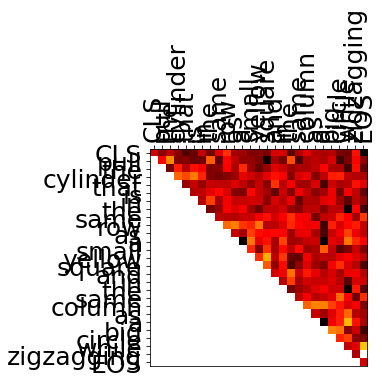

0it [00:00, ?it/s]


In [14]:
from logging import  getLogger
def plot_rpe(run,test_split):
    config, model, command_lang, action_lang = get_model_and_config(run)
    config.batch_size = 1
    test_path = get_test_data_path(config,test_split)

    test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
    # test_dataloader = list(itertools.islice(test_dataloader, 860,862))
    # test_dataloader = list(itertools.islice(test_dataloader, 18,19))
    model.eval()
    losses = 0
    accuracy = 0

    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
    all_errors = []
    for batch_index, data in tqdm(enumerate(test_dataloader)):
        batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
                                                        device,input_mask=data.mask, max_length=config.max_position_embeddings, 
                                                        target_data=data.target_location, include_target=config.include_target,config=config)

        batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                        config.v_feature_size, device)

        batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                            device, max_length=config.target_max_position_embeddings)
        batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                                device, max_length=config.target_max_position_embeddings, no_pad=True)

        batch_target_input = batch_target[:, :-1]
        batch_target_mask_input = batch_target_mask[:, :-1]

        words_embeddings = model.embeddings.word_embeddings(batch_text)
                
        embeddings = model.embeddings.position_embeddings(words_embeddings,True)
        # embeddings.sum()
        # print(embeddings.sum(axis=1).shape)
        plot_text_mask_map(embeddings.sum(axis=1)[0].T,command_lang, batch_text[0],None)

        return 

    return all_errors
normal_wrong = plot_rpe('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','a1')



In [15]:
# def plot_text_mask_map(text_mask,command_lang, text,config):
#     text = [command_lang.index2word[int(x)] for x in text if x != 0]

#     plt.ioff()
#     plt.figure(1)
#     text_mask = text_mask.cpu().detach().numpy()
#     fig, ax = plt.subplots()
#     ax.xaxis.set_ticks_position('top') # the rest is the same
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="default")

#     ax.set_xticks(np.arange(len(text)))
#     ax.set_yticks(np.arange(len(text)))
#     ax.set_xticklabels(text,fontsize=1)
#     ax.set_yticklabels(text,fontsize=5)
#     ax.tick_params(size=4)
#     ax.xaxis.set_label_position('top') 


#     plt.rcParams['figure.figsize'] = [25, 25]
#     ax.imshow(text_mask[:len(text),:len(text)], cmap='hot', interpolation='nearest',)
#     # plt.rcParams['figure.figsize'] = [24, 28]
#     plt.xticks(fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.show()


# def plot_data(run,split,avg=False,index=860,plot_self=False,text_to_image=True,primitives=False):
#     config, model, command_lang, action_lang = get_model_and_config(run,primitives=primitives)
#     config.batch_size = 1
#     test_path = get_train_data_path(config,"dev",primitives)

#     # test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
#     test_dataloader = memory_data_loader.get(test_path, device, batch_size=config.batch_size,dataloader_fn=dataloader_primitives)
#     test_dataloader = list(itertools.islice(test_dataloader, index,index+1))
#     model.eval()
#     losses = 0
#     accuracy = 0
#     loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)

#     for batch_index, data in tqdm(enumerate(test_dataloader)):
#         batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
#                                                         device,input_mask=data.mask, max_length=config.max_position_embeddings, 
#                                                         target_data=data.target_location, include_target=config.include_target,config=config)
#         # plot_text_mask_map(batch_text_mask[0],command_lang, batch_text[0],None)

#         # return 
#         ###########
#         batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
#                                                                         config.v_feature_size, device)

        
#         input_txt,input_imgs,image_loc,attention_mask,image_attention_mask =  batch_text, batch_world, batch_world_loc, batch_text_mask, batch_world_mask
#         if len(attention_mask.shape) == 2:
#             extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
#         else:
#             extended_attention_mask = attention_mask.unsqueeze(1)
#         extended_image_attention_mask = image_attention_mask.unsqueeze(1).unsqueeze(2)

#         extended_attention_mask = extended_attention_mask
#         extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

#         extended_image_attention_mask = extended_image_attention_mask
#         extended_image_attention_mask = (1.0 - extended_image_attention_mask) * -10000.0

# #         Embeddings for input command and input world state
#         embedding_output = model.embeddings(input_txt)
#         v_embedding_output = model.v_embeddings(input_imgs, image_loc)
# #         print(embedding_output.shape)
# #         print(v_embedding_output.shape)
        
# #         Forward prop through encoder
#         encoded_layers_t, encoded_layers_v, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x), all_attention_wts_b4_dropout = model.encoder(
#             embedding_output,
#             v_embedding_output,
#             extended_attention_mask,
#             extended_image_attention_mask,
#             output_all_attention_wts=True,
#         )
        
            
        
#         item_loc = data.target_location.cpu().detach().numpy()
#         print(np.unravel_index(item_loc.argmax(), item_loc.shape))
#         print(" ".join(filter(lambda x: not x.isupper(),data.input_command[0])))
#         print("Ground Truth",)
#         plt.rcParams['figure.figsize'] = [10, 10]
#         world_plotter.show(split,index,targets=data.target_sequence[batch_index])
        
#         if plot_self:
#             if not avg:
#                 plot_text_heat_map(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)
#             else:   
#                 plot_text_heat_map_avg(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)
#         else:
#             if not avg:
#                 plot_co_heat_map(all_attention_wts_b4_dropout,command_lang, batch_text, batch_world_loc,data.target_location, data,dependency_4_longerdependency_4_longer=run)
#             else:   
#                 plot_text_heat_map_avg(all_attention_wts_l,command_lang, batch_text,test_data_paths=run)
#                 plot_co_heat_map_avg(all_attention_wts_b4_dropout,command_lang, batch_text,batch_world_loc,data.target_location,text_to_image=text_to_image)
#         print(data.target_location[0])
#         plt.show()
#         # document_to_tree(data.input_command[0])

#         break
# plot_data('spatial_dependency','b2',avg=False,index=0,plot_self=False,text_to_image=True,primitives=True)


In [16]:
# def calc_aux_loss_v0(aux_loss_fn, batch_text_mask, all_attention_wts_b4_dropout):
#     total_loss = 0
#     for batch_idx, text_mask in enumerate(batch_text_mask):
#         weights = []
#         for layer_index in range(len(all_attention_wts_b4_dropout)):
#             attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'][batch_idx]
#             weights.append(attn_weight)
#         weights = torch.concat(weights) # num_heads*num_layers, text_lenght, image_lenght
#         for token_idx,token_mask in enumerate(text_mask):
#             main_token_att = weights[:,token_idx,:]
#             indices = torch.where(token_mask == 1)[0].cpu().detach()
#             indices = list(filter(lambda x:x > token_idx,indices ))
#             if not indices: 
#                 continue
#             children_token_att = torch.mean(torch.concat([weights[:,child_idx,:].unsqueeze(0) for child_idx in indices]),dim=0)
#             total_loss += aux_loss_fn(main_token_att.reshape(1,-1),children_token_att.reshape(1,-1)).item()
#     return - total_loss
# def calc_aux_loss_v1(aux_loss_fn, batch_text_mask, weights):
#     total_loss = 0
#     weights = weights.transpose(0,1).transpose(1,3).reshape((batch_text_mask.shape[0],batch_text_mask.shape[1],-1))
#     batch_text_mask = torch.max(torch.triu(batch_text_mask) - torch.eye(batch_text_mask.shape[1],device=batch_text_mask.device),torch.zeros_like(batch_text_mask))
#     for token_idx in range(batch_text_mask.shape[1]):
#         current_token_weights = weights[:,token_idx]
#         token_masks = batch_text_mask[:,token_idx]
#         children = token_masks.unsqueeze(-1) * weights
#         children_mean_weights = torch.mean(children,dim=1,keepdim=True)
#         loss = aux_loss_fn(current_token_weights.reshape((batch_text_mask.shape[0],-1)),children_mean_weights.reshape(batch_text_mask.shape[0],-1))
#         loss = torch.mean(loss)
#         total_loss += loss
#     return - total_loss
# @torch.jit.script
# def calc_aux_loss_v2(batch_text_mask, weights):
#     total_loss = torch.tensor(0)

#     weights = weights.transpose(0,1).transpose(1,3).reshape((batch_text_mask.shape[0],batch_text_mask.shape[1],-1))
#     batch_text_mask = torch.max(torch.triu(batch_text_mask) - torch.eye(batch_text_mask.shape[1],device=batch_text_mask.device),torch.zeros_like(batch_text_mask))
#     for token_idx in range(batch_text_mask.shape[1]):
#         current_token_weights = weights[:,token_idx]
#         token_masks = batch_text_mask[:,token_idx]
#         children = token_masks.unsqueeze(-1) * weights
#         children_mean_weights = torch.mean(children,dim=1,keepdim=True)
#         loss = torch.nn.functional.cosine_similarity(current_token_weights.reshape((batch_text_mask.shape[0],-1)),children_mean_weights.reshape(batch_text_mask.shape[0],-1))
#         loss = torch.mean(loss)
#         total_loss = torch.add(loss, total_loss)
#     return - total_loss
# def aux_loss_test(run,split,avg=False,index=860,plot_self=False):
#     config, model, command_lang, action_lang = get_model_and_config(run)
#     config.batch_size = 10
#     test_path = get_test_data_path(config,split)

#     # test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
#     test_dataloader = memory_data_loader.get(test_path, device, batch_size=config.batch_size,)
#     test_dataloader = list(itertools.islice(test_dataloader, index,index+200))
#     model.eval()
#     losses = 0
#     accuracy = 0
#     loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
#     aux_loss_fn = torch.nn.CosineSimilarity()

#     for batch_index, data in tqdm(enumerate(test_dataloader)):
#         batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
#                                                         device,input_mask=data.mask, max_length=config.max_position_embeddings, 
#                                                         target_data=data.target_location, include_target=config.include_target)
#         ###########
#         # not_ands = (batch_text != command_lang.word2index[')']).long()
#         # not_ands = (batch_text != command_lang.word2index[')']).long()
#         # print("#################!!!!!!",batch_text_mask.sum())
#         # batch_text_mask = batch_text_mask & not_ands
#         ###########
#         batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
#                                                                         config.v_feature_size, device)

#         batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
#                                                             device, max_length=config.target_max_position_embeddings)
#         batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
#                                                 device, max_length=config.target_max_position_embeddings, no_pad=True)
        
#         batch_target_input = batch_target[:, :-1]
#         batch_target_mask_input = batch_target_mask[:, :-1]

#         action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
#                                                 batch_target_input, batch_text_mask, batch_world_mask, 
#                                                 batch_target_mask_input, output_all_encoded_layers=False, 
#                                                 output_all_attention_wts=False)
            
#         batch_target_output = batch_target[:, 1:]

#         loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
#         losses += loss.item() 
#         decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
#                                                     batch_world, batch_world_loc, batch_world_mask, 
#                                                     config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
        
#         weights = []
#         for layer_index in range(len(all_attention_wts_b4_dropout)):
#             attn_weight = all_attention_wts_b4_dropout[layer_index]['attn1'].unsqueeze(0)
#             weights.append(attn_weight)
#         weights = torch.concat(weights)
#         # calc_aux_loss_v1(aux_loss_fn, batch_text_mask, weights)
#         calc_aux_loss_v2(batch_text_mask, weights)
#         # print("####")
# aux_loss_test('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_masked_reascan_1_3312','b2',avg=True,index=1,plot_self=False)

In [17]:
# plot_data('aux_loss_2','b2',avg=True,index=0,plot_self=False,text_to_image=True)

In [18]:
# plot_data('aux_loss_2','b2',avg=True,index=0,plot_self=False,text_to_image=True)

In [19]:
# plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_masked_reascan_3420','b2',avg=True,index=0,plot_self=False,text_to_image=True)


In [20]:
# 3 98.79+-1.51 & 97.02+-2.59 & 99.64+-0.22 & 97.61+-1.94 & 93.28+-2.75 & 98.67+-0.56 & 21.29+-5.48 & 86.61+-1.47

In [21]:
# run = 'train_5'
# config, model, command_lang, action_lang = get_model_and_config(run)
# config.batch_size = 1
# test_path = get_test_data_path(config,'a1')
# test_dataloader = list(dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False))

In [22]:
# import random
# index = 0#random.randint(0,500)
# test_split = 'c1'

In [23]:
# plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_masked_reascan_3420','a2',avg=True,index=0,plot_self=True)

In [24]:
# tensorFromBatch.__module__

In [25]:
# run = 'default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420'
# config, model, command_lang, action_lang = get_model_and_config(run)
# config.batch_size = 1
# test_path = get_test_data_path(config,"a1").replace("test.json","data-compositional-splits.txt")
# print(test_path)
# wp_c1 = WorldPlotter(test_path)


## Alternate Hypothesis Analysis

In [22]:
from logging import  getLogger
def get_all_wrong(run,test_split):
    config, model, command_lang, action_lang = get_model_and_config(run)
    config.batch_size = 128
    test_path = get_test_data_path(config,test_split)
    test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
    # test_dataloader = list(itertools.islice(test_dataloader, 860,862))
    # test_dataloader = list(itertools.islice(test_dataloader, 18,19))
    model.eval()
    losses = 0
    accuracy = 0

    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
    all_errors = []

    with torch.no_grad():
        for batch_index, data in tqdm(enumerate(test_dataloader)):
            batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
                                                            device,input_mask=data.mask, max_length=config.max_position_embeddings, 
                                                            target_data=data.target_location, include_target=config.include_target,config=config)

            batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                            config.v_feature_size, device)

            batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                                device, max_length=config.target_max_position_embeddings)
            batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                                    device, max_length=config.target_max_position_embeddings, no_pad=True)

            batch_target_input = batch_target[:, :-1]
            batch_target_mask_input = batch_target_mask[:, :-1]

            action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
                                                    batch_target_input, batch_text_mask, batch_world_mask, 
                                                    batch_target_mask_input, output_all_encoded_layers=False, 
                                                    output_all_attention_wts=False)
                

            batch_target_output = batch_target[:, 1:]

            loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
            losses += loss.item() 
            decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
                                                        batch_world, batch_world_loc, batch_world_mask, 
                                                        config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
            acc, _, errors = calc_accuracy(decoded_batch, batch_target_no_pad, batch_index, data.input_command, getLogger(), config, [])
            all_errors.extend(errors)

    return all_errors


In [92]:
parsed_wrongs = get_all_wrong('reascan_share_layers_dependency_7813','a2')

language in pos embedding learned
ouptut pos embedding learned
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


636it [04:38,  2.28it/s]


In [94]:
normal_wrongs = get_all_wrong('default_12_6_enc_dec_layers_interleave_co_self_share_layers_reascan_3420','a2')

language in pos embedding learned
ouptut pos embedding learned
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


636it [04:29,  2.36it/s]


In [99]:
len(parsed_wrongs),len(normal_wrongs)
diff = list(set(normal_wrongs) - set(parsed_wrongs))

language in pos embedding learned
ouptut pos embedding learned
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 2, 2)
pull the big blue object that is in the same row as a big square and in the same shape as a small red object while spinning
Ground Truth ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull']
Predicion    ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull']


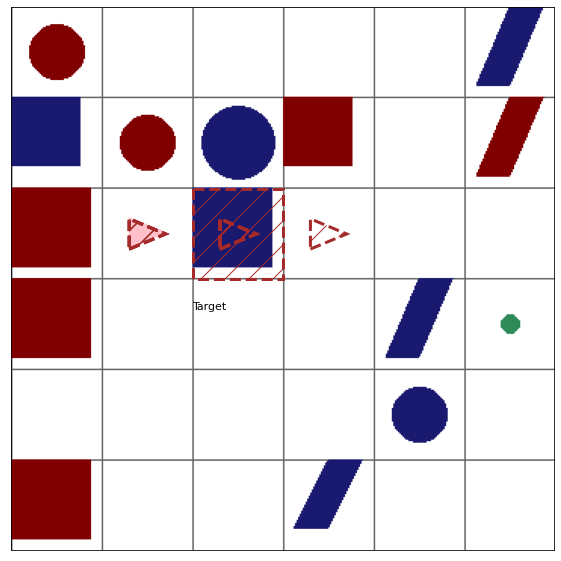

pull


  0%|          | 0/1 [00:00<?, ?it/s]


<Figure size 720x720 with 0 Axes>

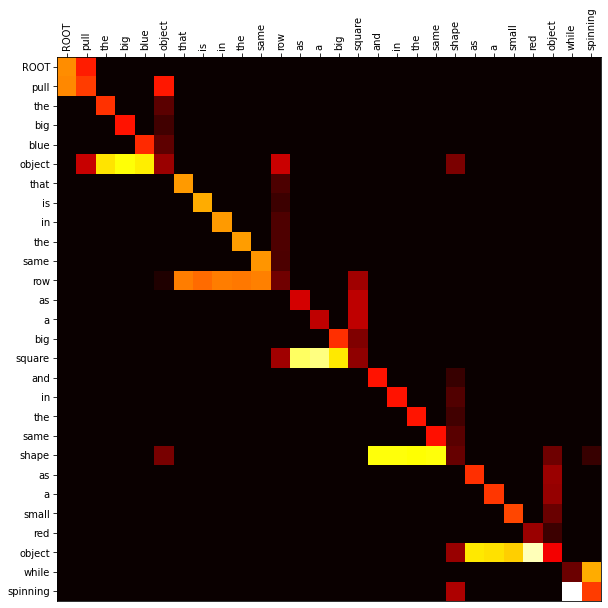

0it [00:00, ?it/s]


In [106]:
plot_data('reascan_share_layers_dependency_7813','a2',avg=True,index=diff[5],plot_self=False,text_to_image=True,show_target=True,show_size=False,apply_commands=True,wrong_target=None)

language in pos embedding learned
ouptut pos embedding learned
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 2, 2)
pull the big blue object that is in the same row as a big square and in the same shape as a small red object while spinning
Ground Truth ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull']
Predicion    ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk']


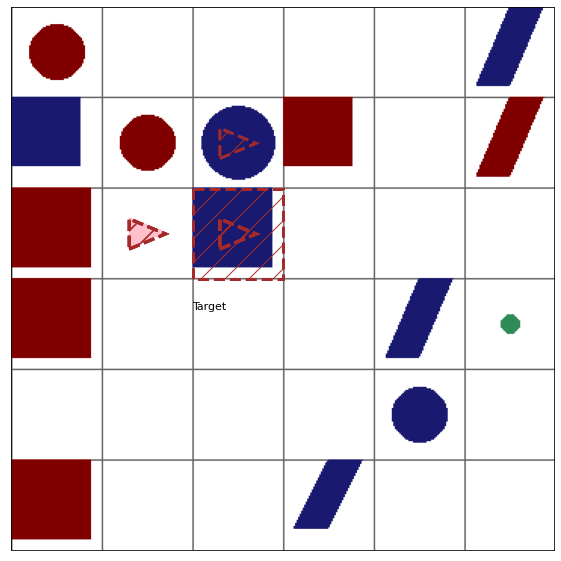

walk


  0%|          | 0/1 [00:00<?, ?it/s]


<Figure size 720x720 with 0 Axes>

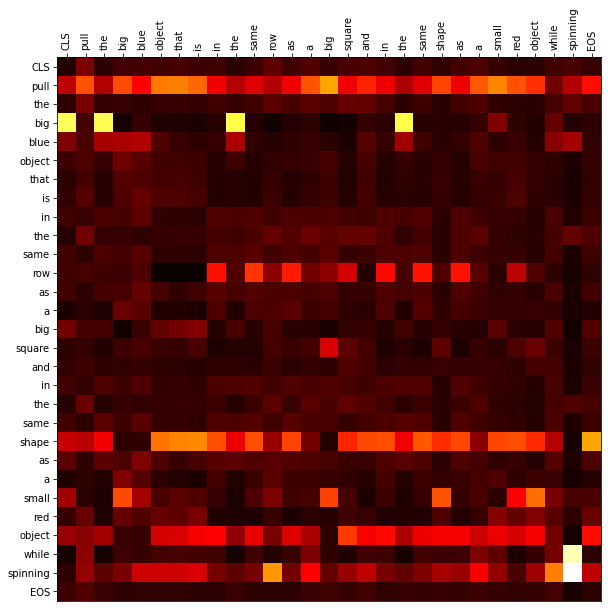

0it [00:00, ?it/s]


In [107]:
plot_data('default_12_6_enc_dec_layers_interleave_co_self_share_layers_reascan_3420','a2',avg=True,index=diff[5],plot_self=False,text_to_image=True,show_target=True,show_size=False,apply_commands=True,wrong_target=None)

In [29]:
# def cal_total_len(run,test_split):
#     config, model, command_lang, action_lang = get_model_and_config(run)
#     config.batch_size = 1
#     test_path = get_test_data_path(config,test_split)
#     test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
#     return len(test_dataloader)
# 1- (len(parsed_wrongs) / cal_total_len('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','c2'))

In [30]:
# plot_data('reascan_share_layers_dependency_7813','c2',avg=True,index=parsed_wrongs[0],plot_self=False,text_to_image=True,show_target=True,show_size=False,apply_commands=True,wrong_target=None)

NameError: name 'parsed_wrongs' is not defined

In [24]:

run = 'default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_6472'#'dependency_rpe'#default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420
# normal_wrong_with_sub = get_all_wrong('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','b2',do_sub=True)
normal_wrong = get_all_wrong(run,'b2')


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


53it [00:24,  2.12it/s]


In [90]:
# len(normal_wrong_with_sub), len(normal_wrong)
from src.utils.parse import DKStanfordDependencyParser
dep_parser = DKStanfordDependencyParser()
# dep_parser.get_parse_tree_masking(filter(str.islower,['ROOT', 'hello', 'this', 'is', 'me']))
stanza_model_dep("pull the blue square")

2023-08-13 17:21:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-13 17:21:43 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-08-13 17:21:43 INFO: Use device: gpu
2023-08-13 17:21:43 INFO: Loading: tokenize
2023-08-13 17:21:43 INFO: Loading: pos
2023-08-13 17:21:43 INFO: Loading: lemma
2023-08-13 17:21:43 INFO: Loading: depparse
2023-08-13 17:21:43 INFO: Done loading processors!


[
  [
    {
      "id": 1,
      "text": "pull",
      "lemma": "pull",
      "upos": "VERB",
      "xpos": "VB",
      "feats": "Mood=Imp|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 0,
      "end_char": 4
    },
    {
      "id": 2,
      "text": "the",
      "lemma": "the",
      "upos": "DET",
      "xpos": "DT",
      "feats": "Definite=Def|PronType=Art",
      "head": 4,
      "deprel": "det",
      "start_char": 5,
      "end_char": 8
    },
    {
      "id": 3,
      "text": "blue",
      "lemma": "blue",
      "upos": "ADJ",
      "xpos": "JJ",
      "feats": "Degree=Pos",
      "head": 4,
      "deprel": "amod",
      "start_char": 9,
      "end_char": 13
    },
    {
      "id": 4,
      "text": "square",
      "lemma": "square",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "head": 1,
      "deprel": "obj",
      "start_char": 14,
      "end_char": 20
    }
  ]
]

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers
385 6660


  0%|          | 0/6660 [00:00<?, ?it/s]

<Figure size 1800x1800 with 0 Axes>

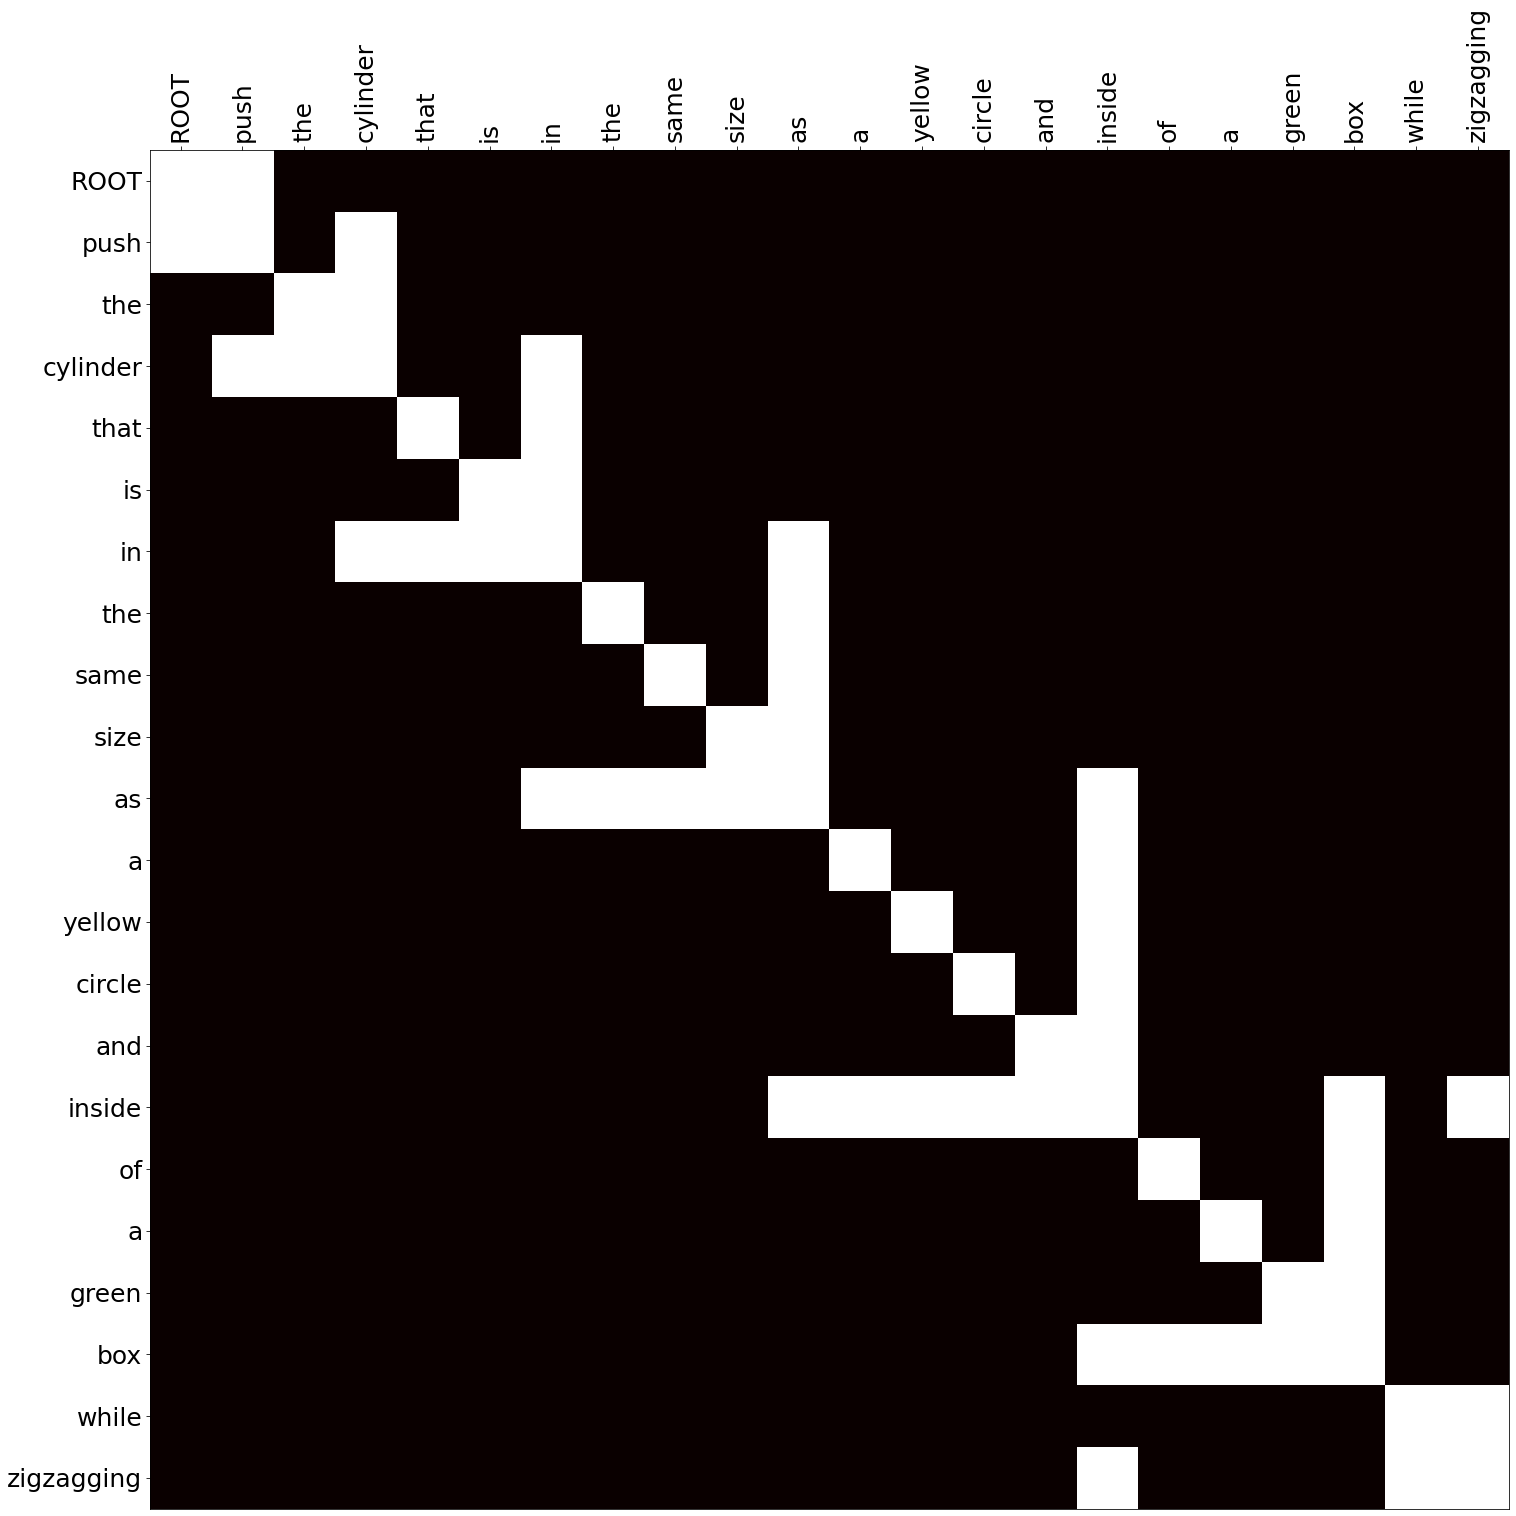

  0%|          | 0/6660 [00:00<?, ?it/s]


In [79]:
from logging import  getLogger
def get_all_wrong_with_sub(run,test_split,indexes,reparse=False):
    config, model, command_lang, action_lang = get_model_and_config(run)
    config.batch_size = 1
    test_path = get_test_data_path(config,test_split)
    test_dataloader = list(dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False))
    print(len(indexes),len(test_dataloader))
    model.eval()
    losses = 0
    accuracy = 0

    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
    all_errors = []
    for batch_index, data in tqdm(enumerate(test_dataloader),total=len(test_dataloader)):
        # if batch_index not in indexes:
        #     continue
        masks = data.mask

        new_commands = list(map(subtitue,data.input_command))
        # if reparse:
        #     masks = [dep_parser.get_parse_tree_masking(filter(str.islower,new_commands[0]))[1]]
        batch_text, batch_text_mask = tensorFromBatch(command_lang, new_commands, 
                                                        device,input_mask=masks, max_length=config.max_position_embeddings, 
                                                        target_data=data.target_location, include_target=config.include_target,config=config)

        plot_text_mask_map(batch_text_mask[0],command_lang, batch_text[0],None)
        return 
        
        batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                        config.v_feature_size, device)

        batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                            device, max_length=config.target_max_position_embeddings)
        batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                                device, max_length=config.target_max_position_embeddings, no_pad=True)

        batch_target_input = batch_target[:, :-1]
        batch_target_mask_input = batch_target_mask[:, :-1]

        action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
                                                batch_target_input, batch_text_mask, batch_world_mask, 
                                                batch_target_mask_input, output_all_encoded_layers=False, 
                                                output_all_attention_wts=False)
            

        batch_target_output = batch_target[:, 1:]

        loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
        losses += loss.item() 
        decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
                                                    batch_world, batch_world_loc, batch_world_mask, 
                                                    config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
        acc, _, errors = calc_accuracy(decoded_batch, batch_target_no_pad, batch_index, data.input_command, getLogger(), config, [])
        all_errors.extend(errors)
    return all_errors
get_all_wrong_with_sub('dependency_rpe','b2',parsed_wrongs,reparse=True)

In [64]:
res = get_all_wrong_with_sub(run,'b2',normal_wrong)


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


374 6660


100%|██████████| 6660/6660 [16:00<00:00,  6.93it/s]


In [70]:
len(res)/ len(normal_wrong)

0.9919786096256684

In [46]:
parsed_wrongs = get_all_wrong('dependency_rpe','b2')

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


10it [00:04,  2.16it/s]


KeyboardInterrupt: 

In [72]:
# (set(res) & set(normal_wrong) ) - (set(res) or set(normal_wrong))
(set(res) - set(normal_wrong))

{425,
 512,
 653,
 1010,
 1053,
 1137,
 1607,
 1655,
 2304,
 2977,
 3014,
 3422,
 3824,
 4416,
 5015,
 5180,
 5492,
 5765}

In [75]:
len(parsed_wrongs)/ len(normal_wrong)

(385, 374)

In [51]:
res_1 = get_all_wrong_with_sub('dependency_rpe','b2',parsed_wrongs,reparse=True)


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers
385 6660


6660it [16:04,  6.90it/s]


In [81]:
len(set(res_1) & set(parsed_wrongs) )/len(set(res_1) or set(parsed_wrongs))
# len(set(res_1))/len(set(parsed_wrongs))

0.8743589743589744

In [ ]:
# def cal_total_len(run,test_split):
#     config, model, command_lang, action_lang = get_model_and_config(run)
#     config.batch_size = 1
#     test_path = get_test_data_path(config,test_split)
#     test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
#     return len(test_dataloader)
# 1- (len(res) / cal_total_len(run,'b2'))

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0.9244744744744745

In [ ]:
# set(normal_wrong) - set(parsed_wrongs)

{10,
 37,
 52,
 97,
 109,
 116,
 118,
 128,
 134,
 160,
 170,
 181,
 195,
 197,
 200,
 218,
 227,
 230,
 237,
 245,
 246,
 259,
 290,
 303,
 321,
 333,
 337,
 359,
 363,
 393,
 395,
 407,
 411,
 415,
 427,
 434,
 446,
 467,
 470,
 487,
 506,
 507,
 509,
 517,
 524,
 531,
 548,
 566,
 592,
 607,
 625,
 647,
 666,
 674,
 693,
 694,
 696,
 703,
 704,
 716,
 717,
 724,
 726,
 731,
 737,
 742,
 748,
 764,
 770,
 771,
 775,
 779,
 781,
 794,
 801,
 820,
 823,
 835,
 837,
 846,
 859,
 865,
 871,
 889,
 896,
 909,
 910,
 913,
 915,
 917,
 926,
 940,
 943,
 947,
 954,
 957,
 965,
 967,
 968,
 969,
 972,
 987,
 1006,
 1012,
 1021,
 1030,
 1044,
 1050,
 1058,
 1070,
 1077,
 1088,
 1089,
 1093,
 1094,
 1182,
 1193,
 1199,
 1205,
 1207,
 1225,
 1226,
 1237,
 1251,
 1261,
 1282,
 1285,
 1288,
 1307,
 1326,
 1330,
 1343,
 1373,
 1401,
 1402,
 1414,
 1420,
 1452,
 1457,
 1471,
 1482,
 1490,
 1497,
 1499,
 1506,
 1527,
 1529,
 1545,
 1550,
 1581,
 1585,
 1593,
 1604,
 1625,
 1637,
 1661,
 1685,
 1737,


In [82]:
parsed_wrongs = get_all_wrong('reascan_share_layers_dependency_7813','b2')
normal_wrongs = get_all_wrong('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','b2')
# normal_wrongs = get_all_wrong('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_6472','b2')

language in pos embedding learned
ouptut pos embedding learned
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


53it [00:27,  1.90it/s]


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


53it [00:24,  2.15it/s]


In [38]:
normal_wrongs

[37,
 50,
 64,
 91,
 109,
 122,
 152,
 164,
 170,
 181,
 269,
 270,
 281,
 289,
 291,
 325,
 387,
 397,
 427,
 435,
 437,
 473,
 483,
 485,
 486,
 505,
 531,
 559,
 591,
 612,
 666,
 668,
 679,
 685,
 691,
 693,
 702,
 703,
 704,
 717,
 726,
 738,
 754,
 788,
 794,
 799,
 801,
 806,
 807,
 813,
 815,
 837,
 838,
 840,
 853,
 861,
 875,
 883,
 884,
 896,
 901,
 909,
 911,
 913,
 914,
 917,
 923,
 928,
 929,
 933,
 935,
 940,
 943,
 945,
 947,
 948,
 955,
 957,
 963,
 966,
 967,
 972,
 975,
 983,
 986,
 987,
 989,
 991,
 998,
 1006,
 1012,
 1022,
 1027,
 1030,
 1036,
 1047,
 1050,
 1067,
 1076,
 1089,
 1094,
 1101,
 1126,
 1199,
 1225,
 1236,
 1288,
 1350,
 1351,
 1413,
 1415,
 1420,
 1431,
 1496,
 1497,
 1506,
 1557,
 1599,
 1642,
 1674,
 1689,
 1700,
 1726,
 1774,
 1815,
 1861,
 1864,
 1929,
 1952,
 1966,
 1985,
 1999,
 2014,
 2030,
 2031,
 2044,
 2057,
 2071,
 2072,
 2096,
 2110,
 2111,
 2137,
 2142,
 2153,
 2196,
 2209,
 2211,
 2219,
 2257,
 2271,
 2298,
 2299,
 2326,
 2357,
 2426,
 

In [83]:
diff = list(set(normal_wrongs) - set(parsed_wrongs))

In [84]:
len(parsed_wrongs)
# index =  # b2 39 used for paper # 3 diff 10

1579

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 3, 0)
push the blue square that is inside of a big box and in the same size as a blue cylinder while spinning
Ground Truth ['turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk']
Predicion    ['turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk']


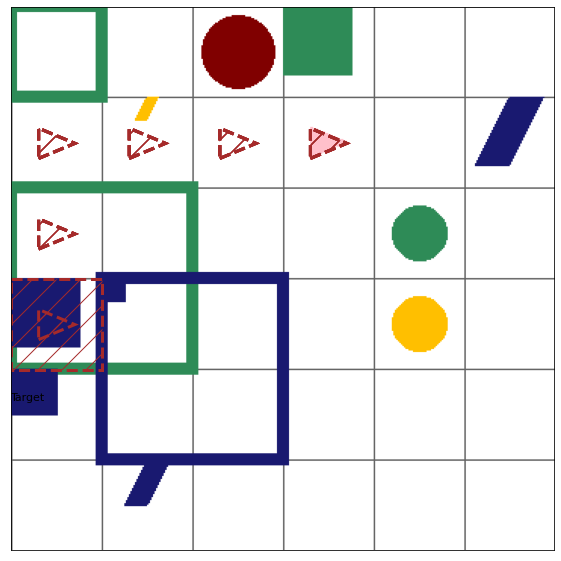

walk


###################### (8, 37, 24)
['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']
['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']
['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']
['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']
['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']
['CLS', 'push', 'the', 'blue', 'square',

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

['CLS', 'push', 'the', 'blue', 'square', 'that', 'is', 'inside', 'of', 'a', 'big', 'box', 'and', 'in', 'the', 'same', 'size', 'as', 'a', 'blue', 'cylinder', 'while', 'spinning', 'EOS']


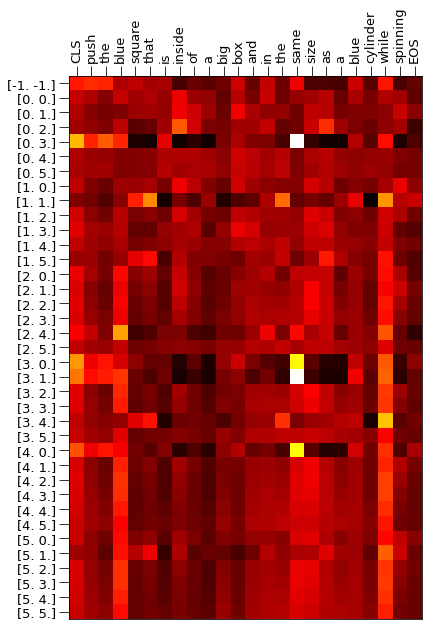

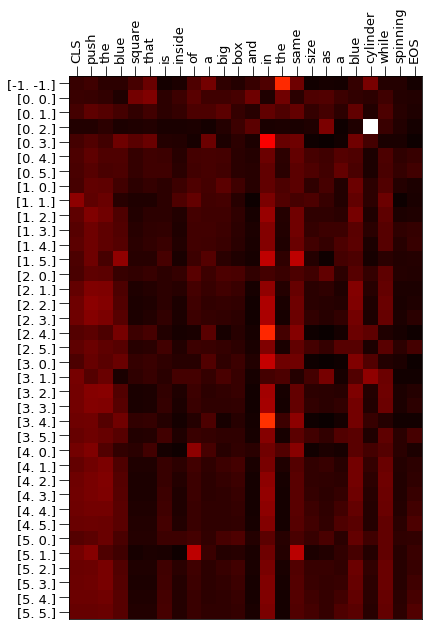

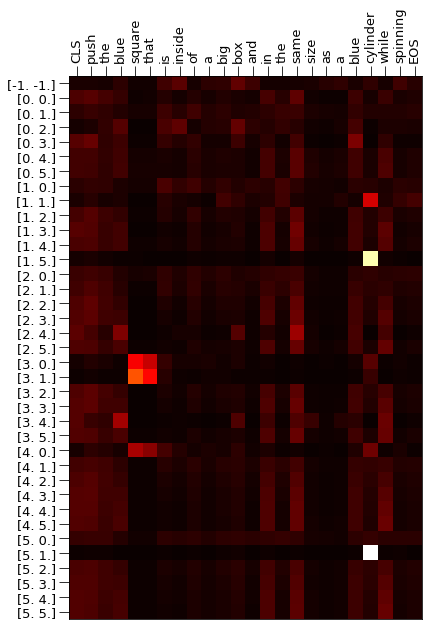

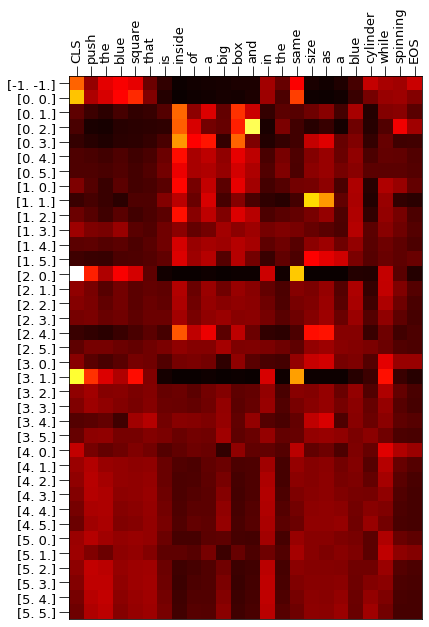

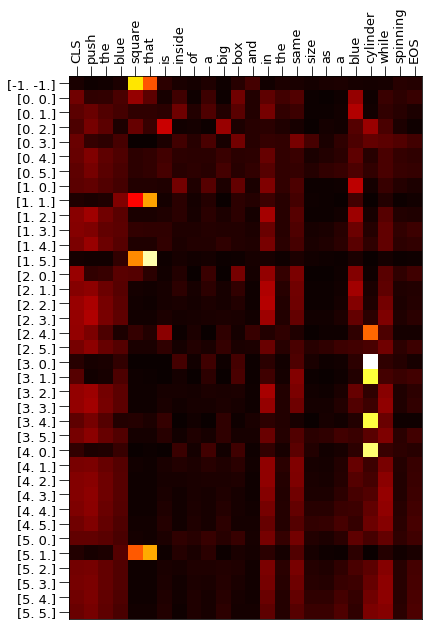

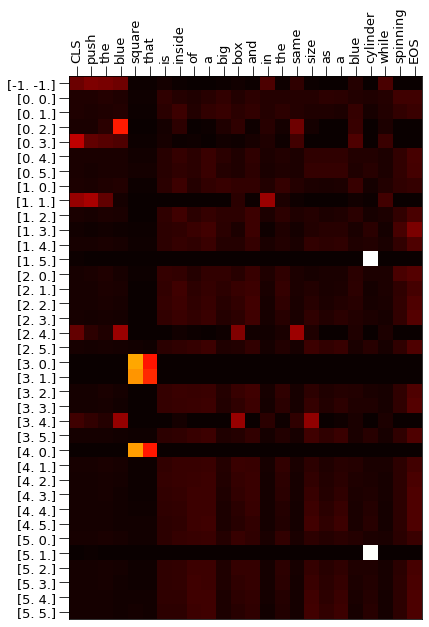

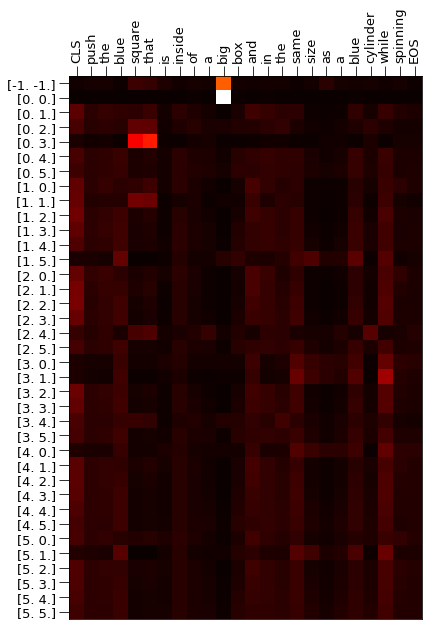

<Figure size 720x720 with 0 Axes>

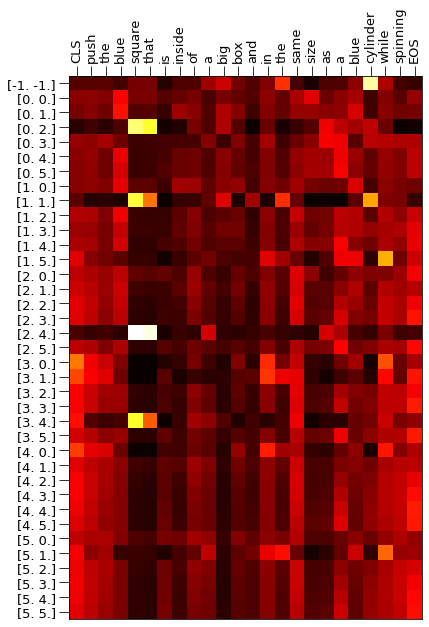

0it [00:04, ?it/s]


In [87]:
# print(diff[0])
plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_6472','b2',avg=False,index=diff[39],plot_self=False,text_to_image=False,show_target=True,show_size=False,apply_commands=True,wrong_target=None)

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 5, 2)
pull the green circle that is inside of a big box and in the same size as a green square while zigzagging
Ground Truth ['turn left', 'turn left', 'walk', 'turn left', 'walk', 'pull', 'pull', 'pull']
Predicion    ['turn left', 'turn left', 'walk', 'turn left', 'walk', 'pull', 'pull', 'pull']


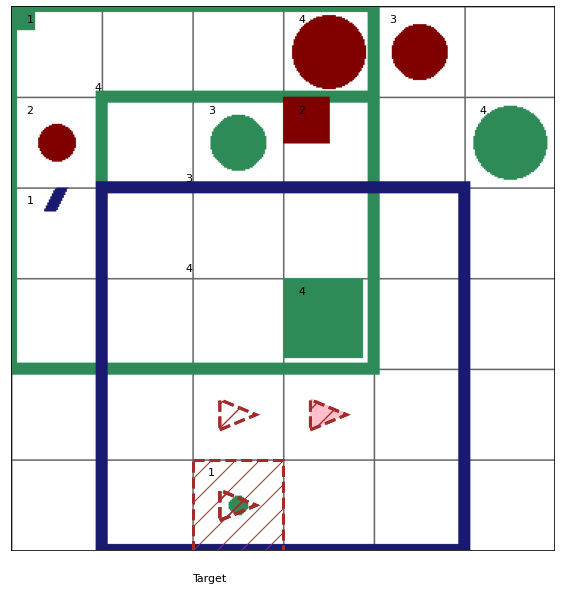

pull


  0%|          | 0/1 [00:00<?, ?it/s]


<Figure size 720x720 with 0 Axes>

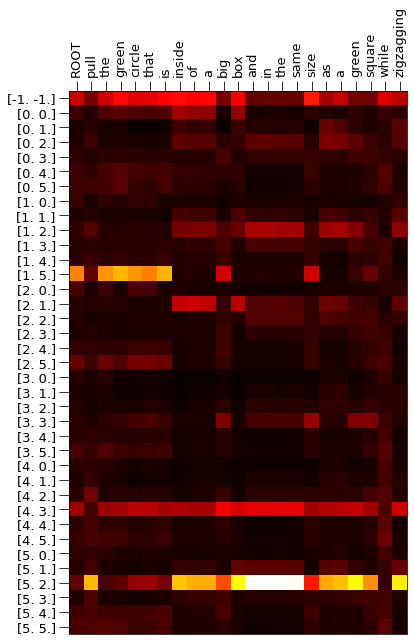

<Figure size 3600x3600 with 0 Axes>

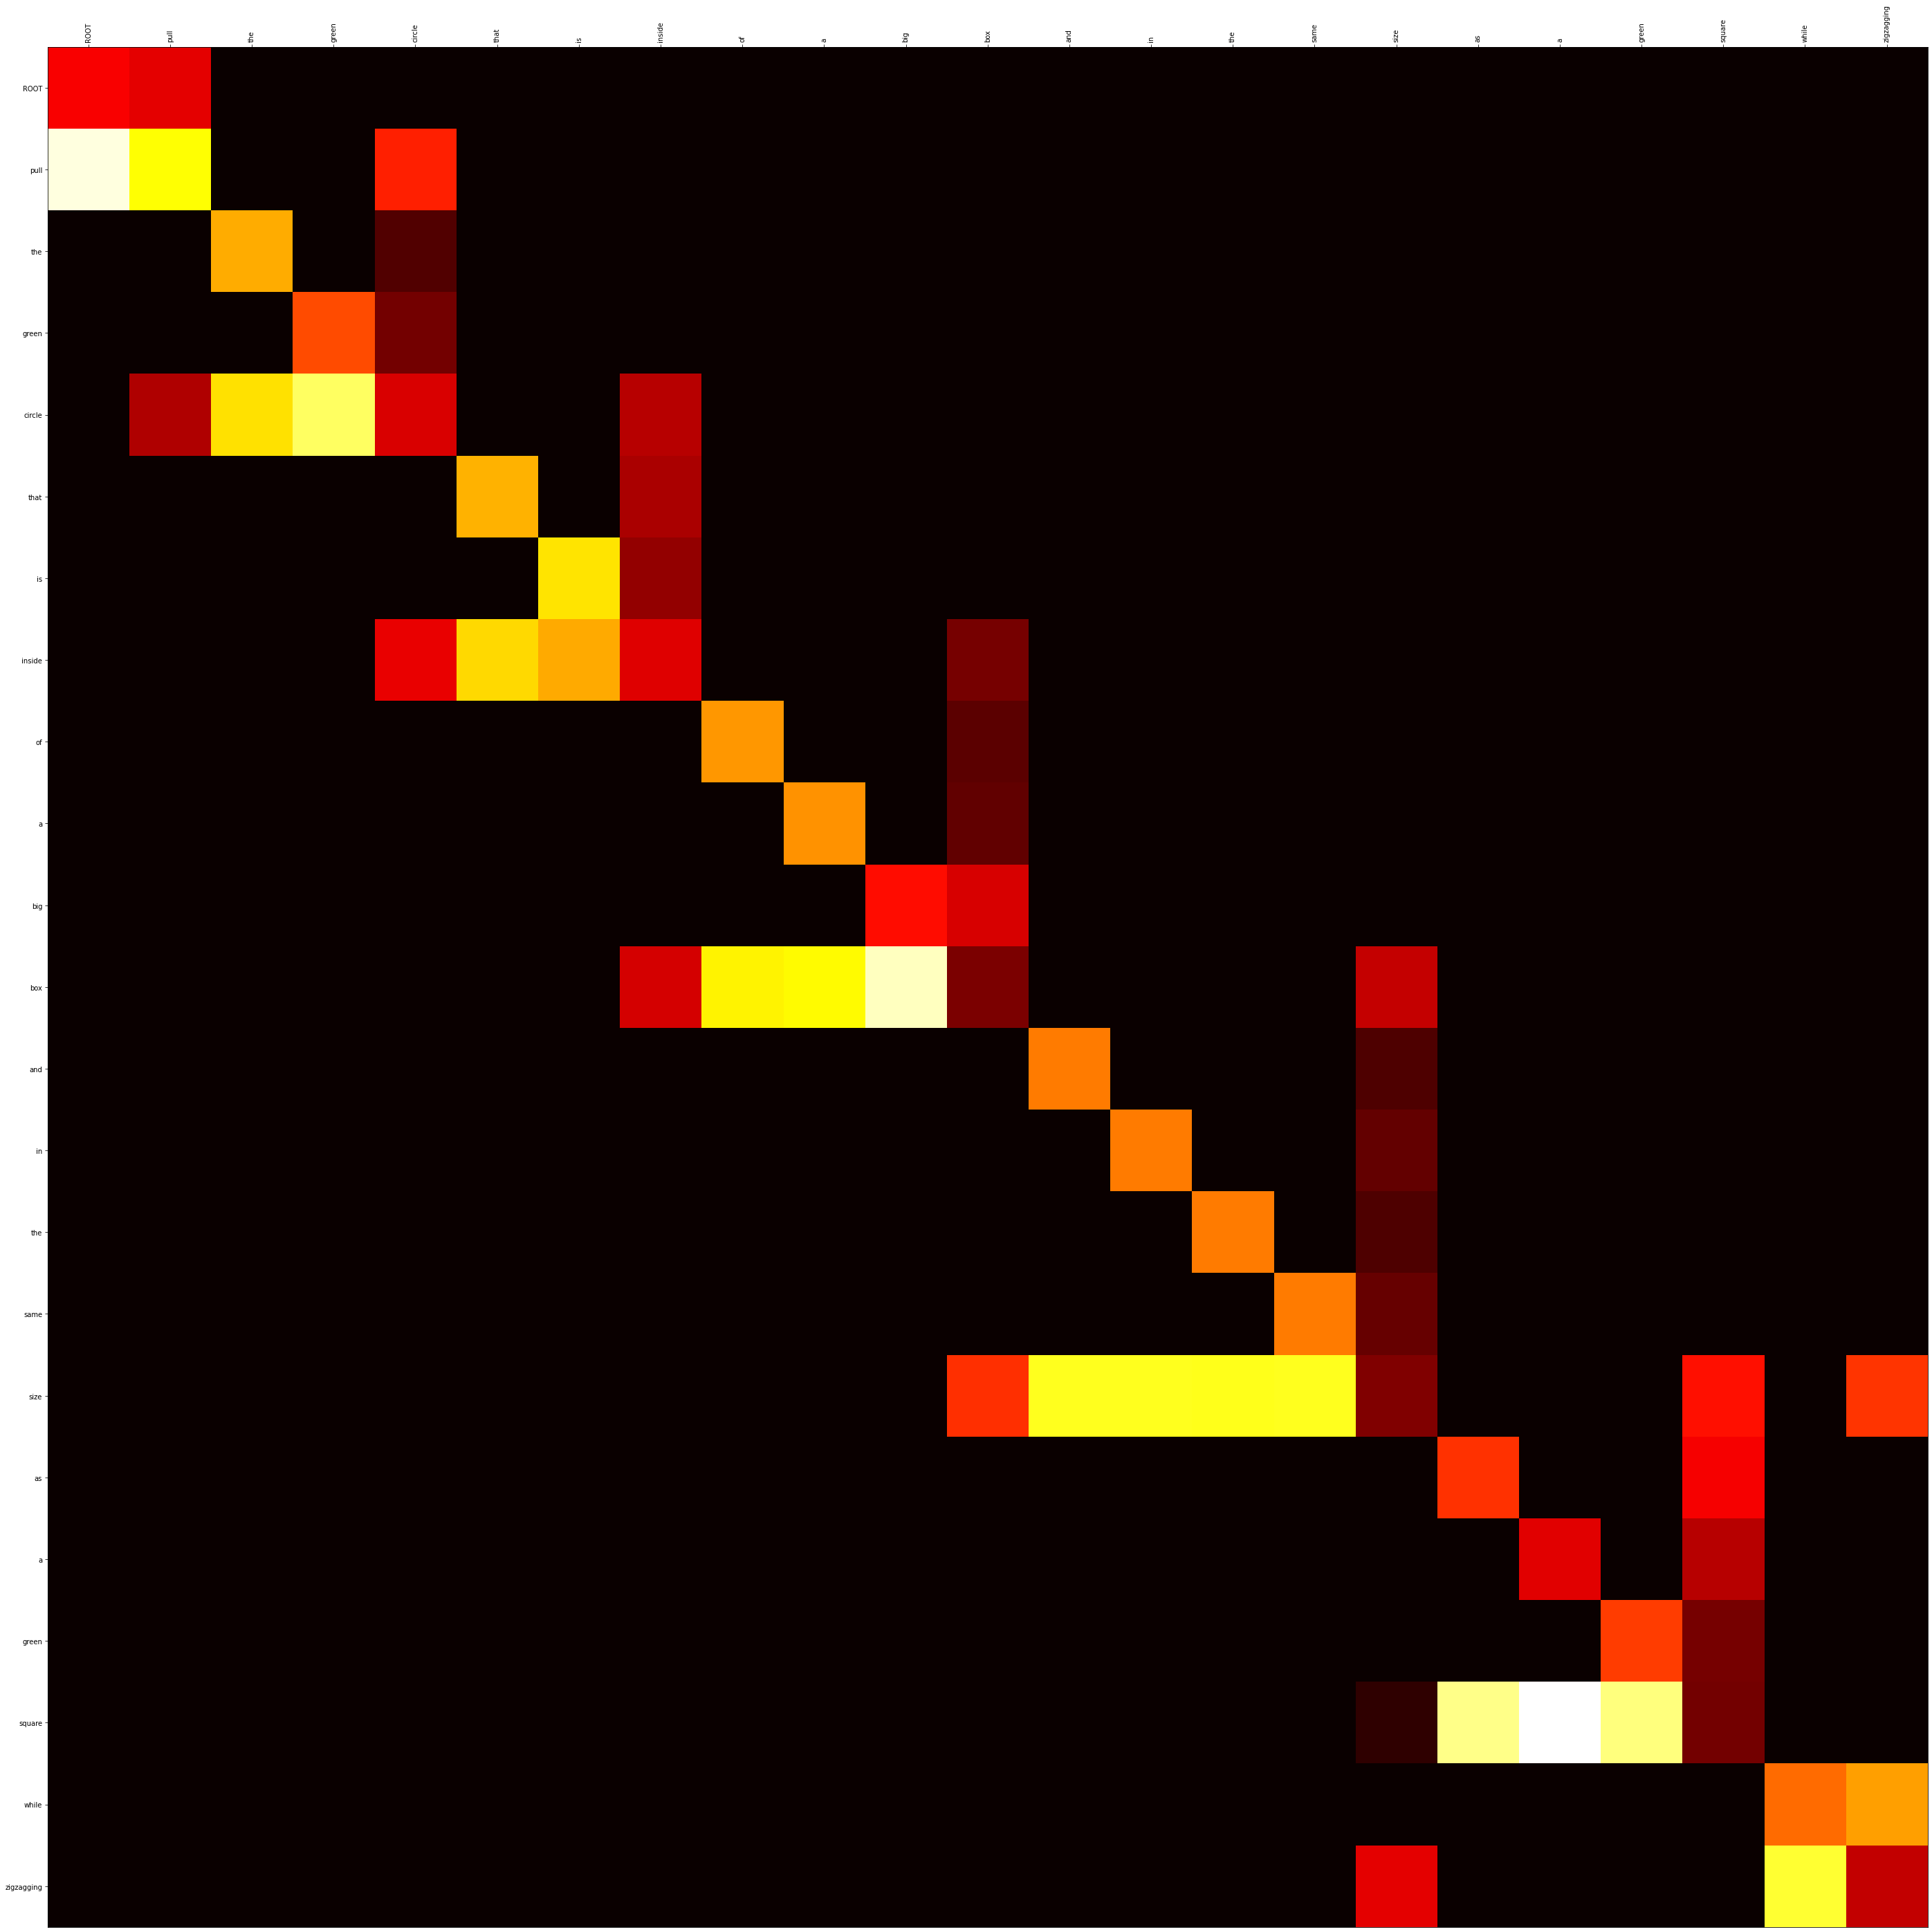

0it [00:01, ?it/s]


In [138]:
# index +=1
# print(index)
plot_data('dependency_rpe','b2',avg=True,index=diff[39],plot_self=False,text_to_image=True,show_target=True,show_size=True,apply_commands=True,wrong_target=None)

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


0it [00:00, ?it/s]

(0, 2, 3)
pull the green square that is in the same size as a yellow cylinder and inside of a green box while spinning
Ground Truth ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn right', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull']
Predicion    ['turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'turn right', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'walk', 'turn left', 'turn left', 'turn left', 'turn left', 'pull', 'turn left', 'turn left', 'turn left', 'turn left', 'pull']


  0%|          | 0/1 [00:00<?, ?it/s]


<Figure size 720x720 with 0 Axes>

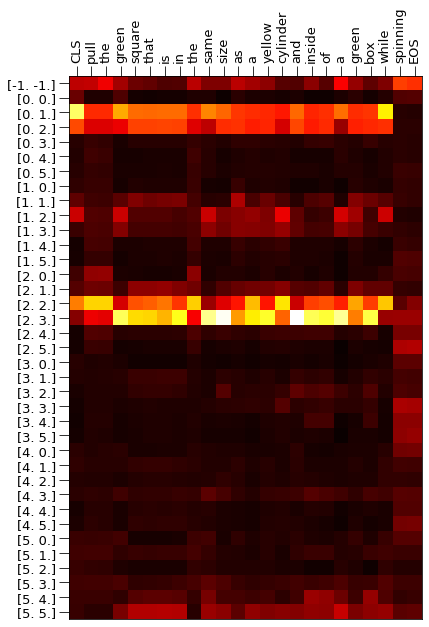

<Figure size 3600x3600 with 0 Axes>

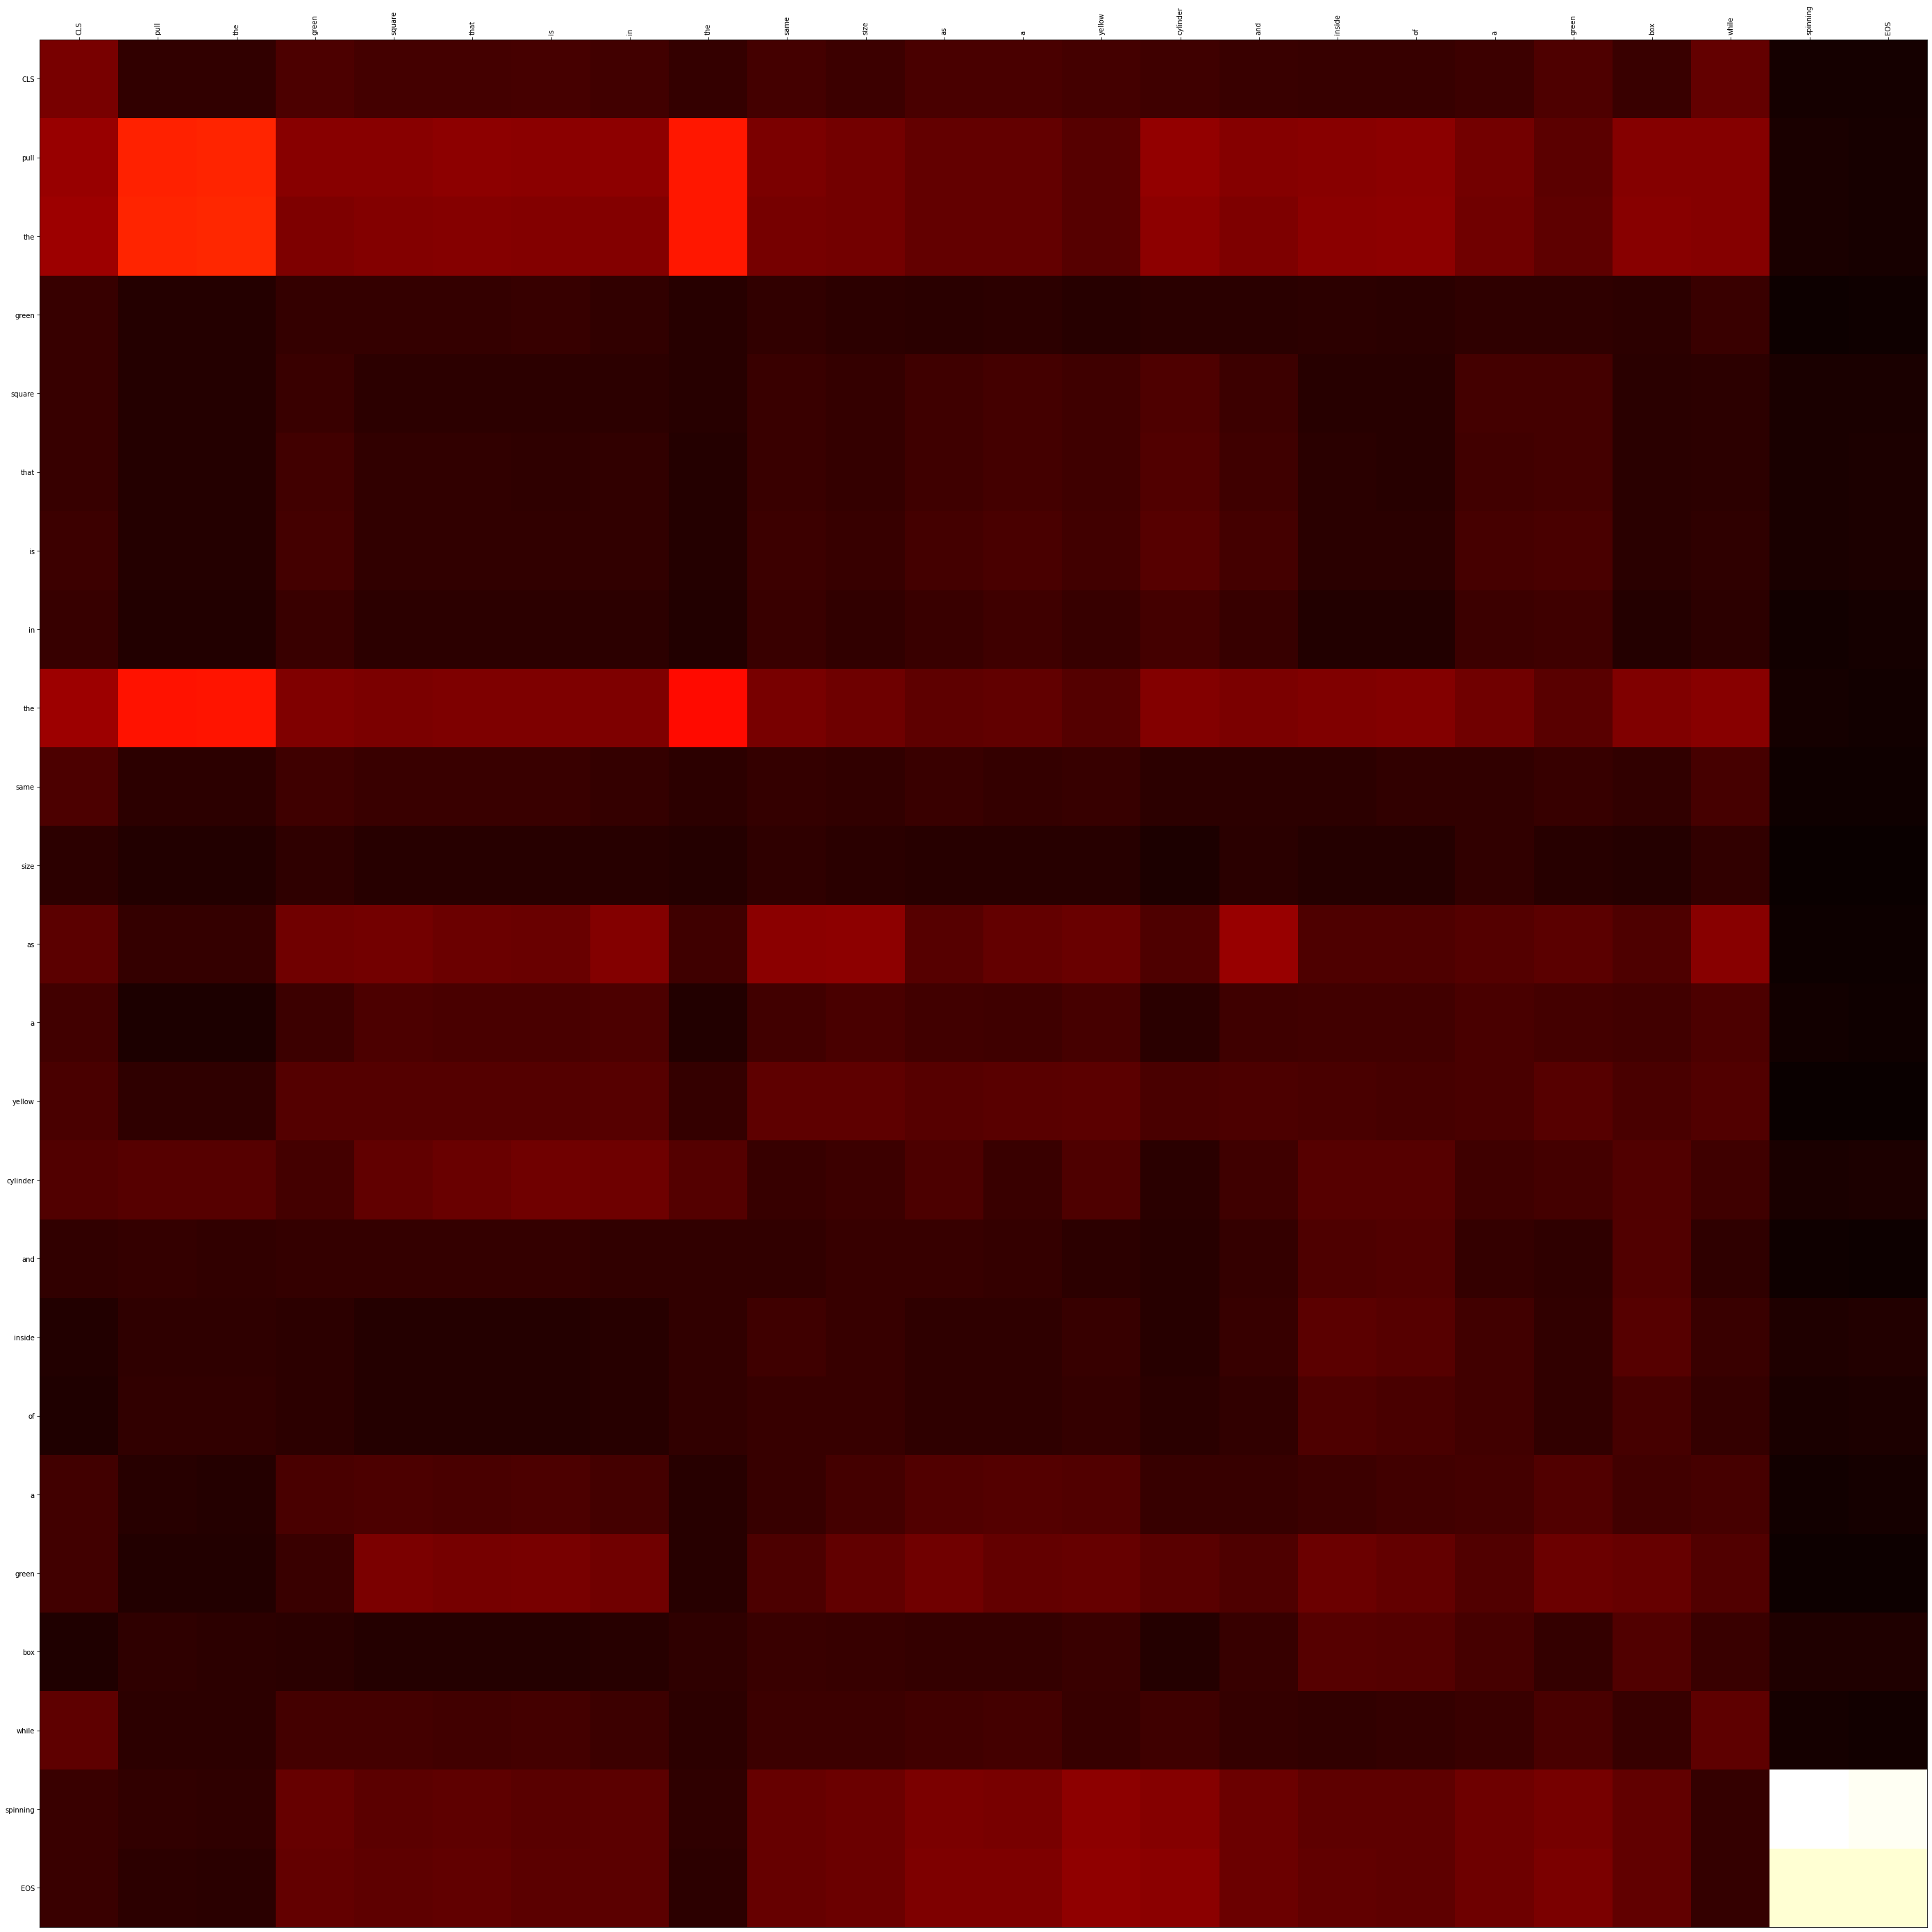

0it [00:01, ?it/s]


In [130]:
plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','b2',avg=True,index=diff[index],plot_self=False,text_to_image=True,show_target=True,show_size=False,apply_commands=True)


In [ ]:
# plot_data('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420',test_split,True,18)


In [ ]:
from logging import  getLogger
def experiment_replacement(run,split):
    config, model, command_lang, action_lang = get_model_and_config(run)
    config.batch_size = 32
    test_path = get_test_data_path(config,split)
    print(test_path)
    test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
    # test_dataloader = list(itertools.islice(test_dataloader, 860,862))
    # test_dataloader = list(itertools.islice(test_dataloader, 18,19))
    model.eval()
    losses = 0
    accuracy = 0

    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
    all_errors = []
    for batch_index, data in tqdm(enumerate(test_dataloader)):
        batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
                                                        device, max_length=config.max_position_embeddings, 
                                                        target_data=data.target_location, include_target=config.include_target)
        
        not_ands = (batch_text != command_lang.word2index['and']).long()
        # print(batch_text_mask.sum())
        batch_text_mask = batch_text_mask & not_ands
        # print(batch_text_mask.sum())

        batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                        config.v_feature_size, device)

        batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                            device, max_length=config.target_max_position_embeddings)
        batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                                device, max_length=config.target_max_position_embeddings, no_pad=True)

        batch_target_input = batch_target[:, :-1]
        batch_target_mask_input = batch_target_mask[:, :-1]

        action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
                                                batch_target_input, batch_text_mask, batch_world_mask, 
                                                batch_target_mask_input, output_all_encoded_layers=False, 
                                                output_all_attention_wts=False)
            

        batch_target_output = batch_target[:, 1:]

        loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
        losses += loss.item() 
        decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
                                                    batch_world, batch_world_loc, batch_world_mask, 
                                                    config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
        acc, _, errors = calc_accuracy(decoded_batch, batch_target_no_pad, batch_index, data.input_command, getLogger(), config, [])
        all_errors.extend(errors)
        accuracy += acc
    return accuracy / len(test_dataloader),all_errors

In [ ]:
experiment_replacement('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_reascan_3420','c2')

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers
./data//ReaSCAN-v1.1/ReaSCAN-compositional-c2/test.json


251it [02:17,  1.83it/s]


(0.1897410358565737,
 [0,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  31,
  32,
  33,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  48,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  61,
  62,
  64,
  65,
  66,
  68,
  70,
  71,
  72,
  73,
  74,
  76,
  78,
  79,
  81,
  82,
  83,
  84,
  85,
  86,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  100,
  101,
  102,
  103,
  106,
  107,
  108,
  109,
  110,
  112,
  113,
  114,
  116,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  132,
  133,
  135,
  136,
  137,
  139,
  140,
  141,
  142,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  164,
  165,
  166,
  167,
  168,
  170,
  171,
  172,
  173,
  174,
  177,
  179,
  180,
  181,
  183,
  184,
  185,

In [ ]:
experiment_replacement('default_12_6_enc_dec_layers_interleave_co_self_text_rpe_share_layers_parsed_reascan_3420','c2')

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


262it [02:31,  1.73it/s]


(0.9922471374045801,
 [16,
  36,
  144,
  147,
  592,
  594,
  851,
  916,
  1005,
  1006,
  1007,
  1166,
  1167,
  1349,
  1612,
  1675,
  2001,
  2142,
  2207,
  2744,
  2900,
  2915,
  3028,
  3040,
  3041,
  3080,
  3171,
  3403,
  3568,
  3599,
  3603,
  3637,
  3647,
  3980,
  4146,
  4217,
  4341,
  4372,
  4374,
  4552,
  4744,
  4927,
  5107,
  5168,
  5169,
  5241,
  5573,
  5819,
  5833,
  6207,
  6208,
  6234,
  6481,
  6669,
  6957,
  7146,
  7413,
  7436,
  7613,
  7614,
  7827,
  7894,
  7914,
  8054,
  8070])

In [ ]:
config, model, command_lang, action_lang = get_model_and_config(run)
command_lang.word2index

language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


{'PAD': 0,
 'SOS': 1,
 'EOS': 2,
 'CLS': 3,
 'push': 4,
 'the': 5,
 'big': 6,
 'green': 7,
 'object': 8,
 'that': 9,
 'is': 10,
 'in': 11,
 'same': 12,
 'row': 13,
 'as': 14,
 'square': 15,
 'cautiously': 16,
 'pull': 17,
 'a': 18,
 'circle': 19,
 'and': 20,
 'column': 21,
 'small': 22,
 'yellow': 23,
 'walk': 24,
 'to': 25,
 'inside': 26,
 'of': 27,
 'red': 28,
 'box': 29,
 'hesitantly': 30,
 'cylinder': 31,
 'color': 32,
 'while': 33,
 'zigzagging': 34,
 'blue': 35,
 'shape': 36,
 'spinning': 37,
 'size': 38}

In [ ]:
from logging import  getLogger

config, model, command_lang, action_lang = get_model_and_config(run)
config.batch_size = 1
test_path = get_test_data_path(config,test_split)

test_dataloader = dataloader(test_path, device, batch_size=config.batch_size, random_shuffle=False)
test_dataloader = list(itertools.compress(test_dataloader,list(normal_wrong)))

# test_dataloader = list(itertools.islice(test_dataloader, 860,862))
# test_dataloader = list(itertools.islice(test_dataloader, 18,19))
model.eval()
losses = 0
accuracy = 0

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
all_errors = []
for batch_index, data in tqdm(enumerate(test_dataloader)):
    batch_text, batch_text_mask = tensorFromBatch(command_lang, data.input_command, 
                                                    device, max_length=config.max_position_embeddings, 
                                                    target_data=data.target_location, include_target=config.include_target)

    batch_world, batch_world_mask, batch_world_loc = worldFromBatch(data.situation, 
                                                                    config.v_feature_size, device)

    batch_target, batch_target_mask = tensorFromBatch(action_lang, data.target_sequence, 
                                                        device, max_length=config.target_max_position_embeddings)
    batch_target_no_pad = tensorFromBatch(action_lang, data.target_sequence, 
                                            device, max_length=config.target_max_position_embeddings, no_pad=True)

    batch_target_input = batch_target[:, :-1]
    batch_target_mask_input = batch_target_mask[:, :-1]

    action_pred, _, _, _, _, _, _ = model(batch_text, batch_world, batch_world_loc, 
                                            batch_target_input, batch_text_mask, batch_world_mask, 
                                            batch_target_mask_input, output_all_encoded_layers=False, 
                                            output_all_attention_wts=False)
        

    batch_target_output = batch_target[:, 1:]

    loss = loss_fn(action_pred.reshape(-1, action_pred.shape[-1]), batch_target_output.reshape(-1))
    losses += loss.item() 
    decoded_batch, all_attention_wts_b4_dropout, (all_attention_wts_l, all_attention_wts_v, all_attention_wts_x) = greedy_decode_batch_dual(model, batch_text, batch_text_mask, 
                                                batch_world, batch_world_loc, batch_world_mask, 
                                                config, device, max_len=config.target_max_position_embeddings,return_attentions=True)
    acc, _, errors = calc_accuracy(decoded_batch, batch_target_no_pad, batch_index, data.input_command, getLogger(), config, [])
    all_errors.extend(errors)
print(all_errors)


language in pos embedding relative
ouptut pos embedding relative
vis pos embedding linear
share_l_layers
share_v_layers
share_x_layers


NameError: name 'normal_wrong' is not defined